# Import packages

In [1]:
# Reading/Writing Data
import os
import glob
import numpy as np
import math 
import matplotlib.pyplot as plt

# Pytorch
import torch 
from torch.utils.data import DataLoader, random_split

# Self-Defined Package
from SMAPDataset import SMAPDataset
from SMCNN import SMCNN
from SDLoss import self_defined_smap_loss
from Preprocessing import random_spatial_sequence, collate_fn, collate_insitu_validation

C:\Users\jianer\anaconda3\envs\datamining\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Some Utility Functions

In [2]:
def same_seed(seed): 
    '''Fixes random number generator seeds for reproducibility.'''
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

# Configurations
`config` contains hyper-parameters for training and the path to save your model.

In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
config = {
    'seed': 11611801,      # Your seed number, you can pick your lucky number. :)
    'is_train': True,
    'test_ratio': 0.2,
    'valid_ratio': 0.1,   # validation_size = train_size * valid_ratio
    'n_epochs': 5000,     # Number of epochs.            
    'train_batch_size': 71*2, 
    'valid_batch_size': 78,
    'test_batch_size': 197,
    'sim_threshold': 0.8,
    'learning_rate': 5e-4,
    'step_size': 10,
    'gamma': 0.5,
    'momentum': 0.9,
    'early_stop': 50,    # If model has not improved for this many consecutive epochs, stop training.     
    'root': 'D:\\1GRADUATED\\paper\\downscaling_data\\Soil_moisture_downscale_czt\\DATASET\\AB',
    'model_save_dir': 'D:\\1GRADUATED\\paper\\downscaling_data\\Soil_moisture_downscale_czt\\DATASET\\AB\\OUTPUT\\MODELS\\CNN_FROM_UPSCALING'
}

# Dataloader
Read data from files and set up training, validation, and testing sets.

In [4]:
# # Set seed for reproducibility
same_seed(config['seed'])

In [5]:
# 创建数据集
dataset = SMAPDataset(config['root'])

D:\1GRADUATED\paper\downscaling_data\Soil_moisture_downscale_czt\DATASET\AB\LABEL\ATI\GRID_70
***************************Load data path******************************
valid day sequence: ['2015104', '2015106', '2015114', '2015115', '2015117', '2015128', '2015130', '2015131', '2015136', '2015138', '2015141', '2015149', '2015154', '2015157', '2015160', '2015162', '2015163', '2015165', '2015171', '2015176', '2015186', '2015187', '2015189', '2015194', '2015195', '2015197', '2015200', '2015202', '2015203', '2015205', '2015208', '2015211', '2015213', '2015216', '2015221', '2015226', '2015229', '2015232', '2015234', '2015235', '2015237', '2015242', '2015243', '2015258', '2015259', '2015261', '2015267', '2015272', '2015275', '2015277', '2015280', '2015282', '2015283', '2015285', '2015288', '2015290', '2015291', '2015296', '2015325', '2015330', '2015333']
_______________________________2015104_______________________________
_____________________________smap cell: 1_____________________________
D

D:\1GRADUATED\paper\downscaling_data\Soil_moisture_downscale_czt\DATASET\AB\INPUT\SMAP\2015205\44.npy
D:\1GRADUATED\paper\downscaling_data\Soil_moisture_downscale_czt\DATASET\AB\INPUT\TEXTURE\44.npy
D:\1GRADUATED\paper\downscaling_data\Soil_moisture_downscale_czt\DATASET\AB\INPUT\NDVI\GRID\2015205\44.npy
D:\1GRADUATED\paper\downscaling_data\Soil_moisture_downscale_czt\DATASET\AB\LABEL\SMAP\2015205\44.npy
D:\1GRADUATED\paper\downscaling_data\Soil_moisture_downscale_czt\DATASET\AB\LABEL\ATI\GRID_70\2015205\44.npy
_____________________________smap cell: 45_____________________________
D:\1GRADUATED\paper\downscaling_data\Soil_moisture_downscale_czt\DATASET\AB\INPUT\SMAP\2015205\45.npy
D:\1GRADUATED\paper\downscaling_data\Soil_moisture_downscale_czt\DATASET\AB\INPUT\TEXTURE\45.npy
D:\1GRADUATED\paper\downscaling_data\Soil_moisture_downscale_czt\DATASET\AB\INPUT\NDVI\GRID\2015205\45.npy
D:\1GRADUATED\paper\downscaling_data\Soil_moisture_downscale_czt\DATASET\AB\LABEL\SMAP\2015205\45.npy
D:\

D:\1GRADUATED\paper\downscaling_data\Soil_moisture_downscale_czt\DATASET\AB\INPUT\SMAP\2015288\22.npy
D:\1GRADUATED\paper\downscaling_data\Soil_moisture_downscale_czt\DATASET\AB\INPUT\TEXTURE\22.npy
D:\1GRADUATED\paper\downscaling_data\Soil_moisture_downscale_czt\DATASET\AB\INPUT\NDVI\GRID\2015288\22.npy
D:\1GRADUATED\paper\downscaling_data\Soil_moisture_downscale_czt\DATASET\AB\LABEL\SMAP\2015288\22.npy
D:\1GRADUATED\paper\downscaling_data\Soil_moisture_downscale_czt\DATASET\AB\LABEL\ATI\GRID_70\2015288\22.npy
_____________________________smap cell: 23_____________________________
D:\1GRADUATED\paper\downscaling_data\Soil_moisture_downscale_czt\DATASET\AB\INPUT\SMAP\2015288\23.npy
D:\1GRADUATED\paper\downscaling_data\Soil_moisture_downscale_czt\DATASET\AB\INPUT\TEXTURE\23.npy
D:\1GRADUATED\paper\downscaling_data\Soil_moisture_downscale_czt\DATASET\AB\INPUT\NDVI\GRID\2015288\23.npy
D:\1GRADUATED\paper\downscaling_data\Soil_moisture_downscale_czt\DATASET\AB\LABEL\SMAP\2015288\23.npy
D:\

In [6]:
# 计算训练集和测试集的长度
train_len = int(len(dataset) * (1-config['test_ratio']))
test_len = len(dataset) - train_len

# 使用 random_split 函数进行划分
train_dataset, test_dataset = random_split(dataset, [train_len, test_len])

# 计算训练集和验证集的长度
valid_len = int(train_len * (config['valid_ratio']))
train_len = train_len - valid_len

# 使用 random_split 函数进行划分
train_dataset, valid_dataset = random_split(train_dataset, [train_len, valid_len])

# 创建数据加载器
train_loader = DataLoader(train_dataset, batch_size=config['train_batch_size'], shuffle=True, collate_fn=collate_fn)
valid_loader = DataLoader(valid_dataset, batch_size=config['valid_batch_size'], shuffle=True, collate_fn=collate_fn)
test_loader = DataLoader(test_dataset, batch_size=config['test_batch_size'], shuffle=False, collate_fn=collate_fn)

print('training size', len(train_dataset))
print('validing size', len(valid_dataset))
print('testing size', len(test_dataset))

training size 710
validing size 78
testing size 197


# Training Loop

In [7]:
def trainer(train_loader, valid_loader, model, config, device):
    relu = torch.nn.ReLU(inplace=True)
    criterion = self_defined_smap_loss 
    optimizer = torch.optim.SGD(model.parameters(), weight_decay=0.01, lr=config['learning_rate'], momentum=config['momentum']) 
    
    # learning rate decay
    RLRP = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=config['gamma'], patience=config['step_size'], threshold=0.03)

    n_epochs, best_loss, step, early_stop_count = config['n_epochs'], math.inf, 0, 0

    for epoch in range(n_epochs):
        if epoch==35:
            config['sim_threshold'] = 0.93
        model.train() # Set your model to train mode.
        
        loss_record = []
        physical_loss_record = []
        sim_loss_record = []
        for data_pkg in train_loader:
            x = data_pkg['processed_data']
            optimizer.zero_grad()               
            pred = model(x)
            relu(pred[:, 0])
#             print(pred)
#             x, pred = x.to(device), pred.to(device)  
            physical_loss, sim_loss = criterion(pred, data_pkg['label_data'], 'Training', config['sim_threshold'])
            loss = physical_loss + sim_loss
            loss.backward()                     
            optimizer.step()                   
            step += 1
            
            physical_loss_record.append(physical_loss.detach().item())
            sim_loss_record.append(sim_loss.detach().item())
            loss_record.append(loss.detach().item())
         
        mean_train_physical_loss = sum(physical_loss_record)/len(physical_loss_record)
        mean_train_sim_loss = sum(sim_loss_record)/len(sim_loss_record)
        mean_train_loss = sum(loss_record)/len(loss_record)

        model.eval() 
        loss_record = []
        physical_loss_record = []
        sim_loss_record = []
        for data_pkg in valid_loader:
            x = data_pkg['processed_data']
            with torch.no_grad():
                pred = model(x)
                relu(pred[:, 0])
#             x, pred = x.to(device), pred.to(device)  
                physical_loss, sim_loss = criterion(pred, data_pkg['label_data'], 'Validing', config['sim_threshold'])
                loss = physical_loss + sim_loss
            
            physical_loss_record.append(physical_loss.item())
            sim_loss_record.append(sim_loss.item())
            loss_record.append(loss.item())

        mean_valid_physical_loss = sum(physical_loss_record)/len(physical_loss_record)
        mean_valid_sim_loss = sum(sim_loss_record)/len(sim_loss_record)
        mean_valid_loss = sum(loss_record)/len(loss_record)
        
        current_lr = (optimizer.param_groups[0])['lr']
        print(f'Epoch [{epoch+1}/{n_epochs}] (LR: {current_lr}):')
        print(f'Train loss: {mean_train_loss:.4f} || Train physical loss: {mean_train_physical_loss:.4f} || Train similarity loss: {mean_train_sim_loss:.4f}')
        print(f'Valid loss: {mean_valid_loss:.4f} || Valid physical loss: {mean_valid_physical_loss:.4f} || Valid similarity loss: {mean_valid_sim_loss:.4f}')
            
        if mean_valid_loss < best_loss:
            best_loss = mean_valid_loss
            _name = str(best_loss)
            _name = 'first'
            torch.save(model.state_dict(), os.path.join(config['model_save_dir'], _name + '.ckpt')) # Save your best model
            print('Saving model with loss {:.3f}...'.format(best_loss))
            print(os.path.join(config['model_save_dir'], _name + '.ckpt'))
            early_stop_count = 0
        else: 
            early_stop_count += 1

        if early_stop_count >= config['early_stop']:
            print('\nModel is not improving, so we halt the training session.')
            _name = str(best_loss)
            _name = 'last'
            torch.save(model.state_dict(), os.path.join(config['model_save_dir'], _name + '.ckpt')) # Save your best model
            return
        #         StepLR.step()
        RLRP.step(mean_valid_loss)

# Start training!

(11, 11, 20)
SMCNN(
  (cnn): Sequential(
    (0): Conv2d(20, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(64, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
  )
  (fc): Sequential(
    (0): Linear(in_features=3872, out_features=4, bias=True)
    (1): ReLU()
    (2): Linear(in_features=4, out_features=2, bias=True)
  )
)


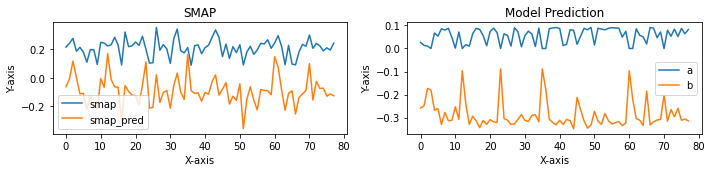

Epoch [1/5000] (LR: 0.0005):
Train loss: 10.8487 || Train physical loss: 0.0679 || Train similarity loss: 10.7807
Valid loss: 10.6879 || Valid physical loss: 0.0955 || Valid similarity loss: 10.5923
Saving model with loss 10.688...
D:\1GRADUATED\paper\downscaling_data\Soil_moisture_downscale_czt\DATASET\AB\OUTPUT\MODELS\CNN_FROM_UPSCALING\first.ckpt


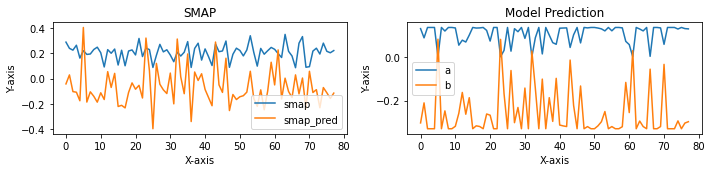

Epoch [2/5000] (LR: 0.0005):
Train loss: 9.9507 || Train physical loss: 0.0937 || Train similarity loss: 9.8571
Valid loss: 10.6071 || Valid physical loss: 0.0925 || Valid similarity loss: 10.5146
Saving model with loss 10.607...
D:\1GRADUATED\paper\downscaling_data\Soil_moisture_downscale_czt\DATASET\AB\OUTPUT\MODELS\CNN_FROM_UPSCALING\first.ckpt


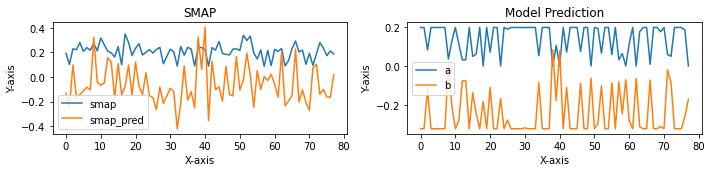

Epoch [3/5000] (LR: 0.0005):
Train loss: 9.5437 || Train physical loss: 0.0992 || Train similarity loss: 9.4445
Valid loss: 10.2684 || Valid physical loss: 0.0940 || Valid similarity loss: 10.1744
Saving model with loss 10.268...
D:\1GRADUATED\paper\downscaling_data\Soil_moisture_downscale_czt\DATASET\AB\OUTPUT\MODELS\CNN_FROM_UPSCALING\first.ckpt


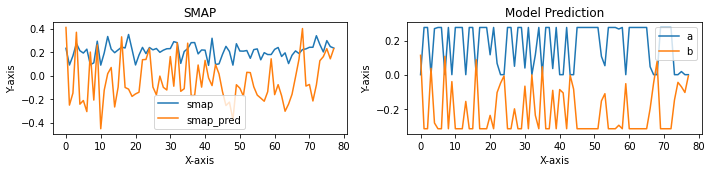

Epoch [4/5000] (LR: 0.0005):
Train loss: 9.2299 || Train physical loss: 0.0959 || Train similarity loss: 9.1339
Valid loss: 9.8268 || Valid physical loss: 0.0951 || Valid similarity loss: 9.7317
Saving model with loss 9.827...
D:\1GRADUATED\paper\downscaling_data\Soil_moisture_downscale_czt\DATASET\AB\OUTPUT\MODELS\CNN_FROM_UPSCALING\first.ckpt


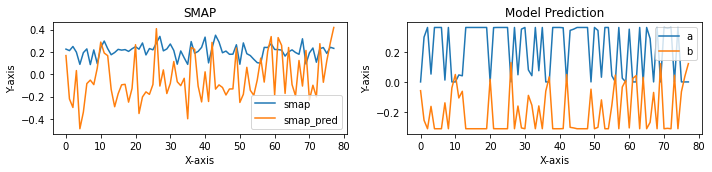

Epoch [5/5000] (LR: 0.0005):
Train loss: 9.2362 || Train physical loss: 0.0941 || Train similarity loss: 9.1421
Valid loss: 9.4953 || Valid physical loss: 0.0970 || Valid similarity loss: 9.3983
Saving model with loss 9.495...
D:\1GRADUATED\paper\downscaling_data\Soil_moisture_downscale_czt\DATASET\AB\OUTPUT\MODELS\CNN_FROM_UPSCALING\first.ckpt


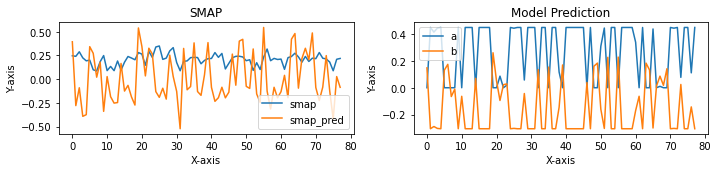

Epoch [6/5000] (LR: 0.0005):
Train loss: 8.9292 || Train physical loss: 0.0983 || Train similarity loss: 8.8310
Valid loss: 9.1669 || Valid physical loss: 0.1057 || Valid similarity loss: 9.0612
Saving model with loss 9.167...
D:\1GRADUATED\paper\downscaling_data\Soil_moisture_downscale_czt\DATASET\AB\OUTPUT\MODELS\CNN_FROM_UPSCALING\first.ckpt


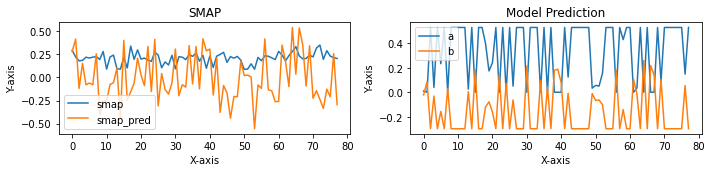

Epoch [7/5000] (LR: 0.0005):
Train loss: 6.9017 || Train physical loss: 0.1073 || Train similarity loss: 6.7944
Valid loss: 8.9764 || Valid physical loss: 0.1115 || Valid similarity loss: 8.8649
Saving model with loss 8.976...
D:\1GRADUATED\paper\downscaling_data\Soil_moisture_downscale_czt\DATASET\AB\OUTPUT\MODELS\CNN_FROM_UPSCALING\first.ckpt


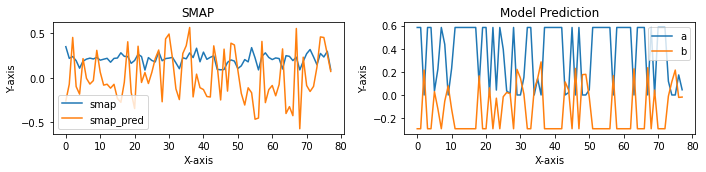

Epoch [8/5000] (LR: 0.0005):
Train loss: 0.7534 || Train physical loss: 0.1014 || Train similarity loss: 0.6520
Valid loss: 0.9425 || Valid physical loss: 0.1148 || Valid similarity loss: 0.8277
Saving model with loss 0.942...
D:\1GRADUATED\paper\downscaling_data\Soil_moisture_downscale_czt\DATASET\AB\OUTPUT\MODELS\CNN_FROM_UPSCALING\first.ckpt


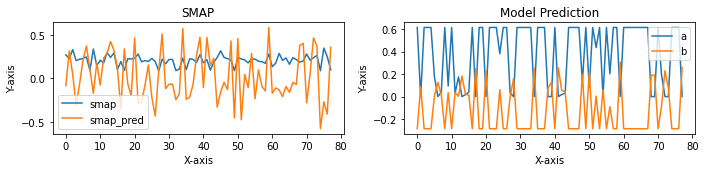

Epoch [9/5000] (LR: 0.0005):
Train loss: 0.4322 || Train physical loss: 0.1101 || Train similarity loss: 0.3221
Valid loss: 0.9381 || Valid physical loss: 0.1164 || Valid similarity loss: 0.8218
Saving model with loss 0.938...
D:\1GRADUATED\paper\downscaling_data\Soil_moisture_downscale_czt\DATASET\AB\OUTPUT\MODELS\CNN_FROM_UPSCALING\first.ckpt


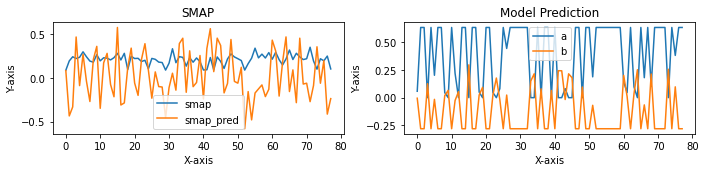

Epoch [10/5000] (LR: 0.0005):
Train loss: 0.5933 || Train physical loss: 0.1073 || Train similarity loss: 0.4861
Valid loss: 0.9411 || Valid physical loss: 0.1136 || Valid similarity loss: 0.8275


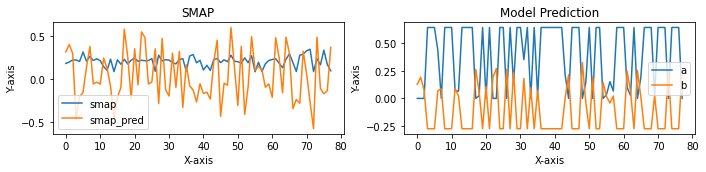

Epoch [11/5000] (LR: 0.0005):
Train loss: 0.5894 || Train physical loss: 0.1034 || Train similarity loss: 0.4860
Valid loss: 0.9332 || Valid physical loss: 0.1151 || Valid similarity loss: 0.8181
Saving model with loss 0.933...
D:\1GRADUATED\paper\downscaling_data\Soil_moisture_downscale_czt\DATASET\AB\OUTPUT\MODELS\CNN_FROM_UPSCALING\first.ckpt


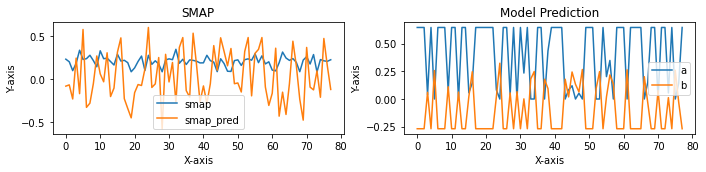

Epoch [12/5000] (LR: 0.0005):
Train loss: 0.7504 || Train physical loss: 0.1014 || Train similarity loss: 0.6489
Valid loss: 0.9330 || Valid physical loss: 0.1121 || Valid similarity loss: 0.8209
Saving model with loss 0.933...
D:\1GRADUATED\paper\downscaling_data\Soil_moisture_downscale_czt\DATASET\AB\OUTPUT\MODELS\CNN_FROM_UPSCALING\first.ckpt


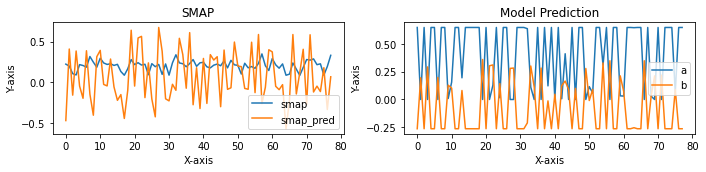

Epoch [13/5000] (LR: 0.0005):
Train loss: 0.5929 || Train physical loss: 0.1095 || Train similarity loss: 0.4834
Valid loss: 0.9217 || Valid physical loss: 0.1183 || Valid similarity loss: 0.8034
Saving model with loss 0.922...
D:\1GRADUATED\paper\downscaling_data\Soil_moisture_downscale_czt\DATASET\AB\OUTPUT\MODELS\CNN_FROM_UPSCALING\first.ckpt


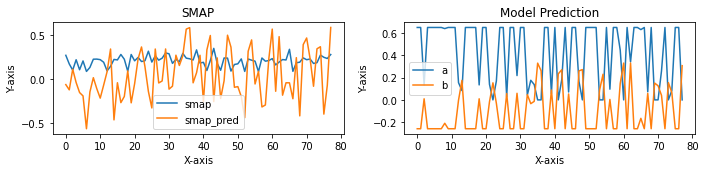

Epoch [14/5000] (LR: 0.0005):
Train loss: 0.7487 || Train physical loss: 0.1000 || Train similarity loss: 0.6488
Valid loss: 0.9287 || Valid physical loss: 0.1058 || Valid similarity loss: 0.8229


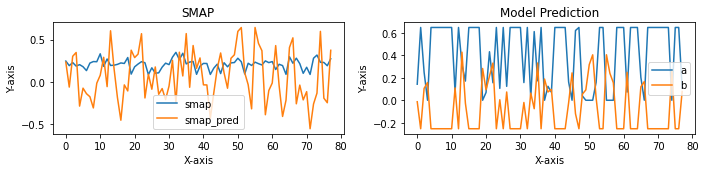

Epoch [15/5000] (LR: 0.0005):
Train loss: 0.5882 || Train physical loss: 0.1024 || Train similarity loss: 0.4858
Valid loss: 0.9195 || Valid physical loss: 0.1081 || Valid similarity loss: 0.8114
Saving model with loss 0.919...
D:\1GRADUATED\paper\downscaling_data\Soil_moisture_downscale_czt\DATASET\AB\OUTPUT\MODELS\CNN_FROM_UPSCALING\first.ckpt


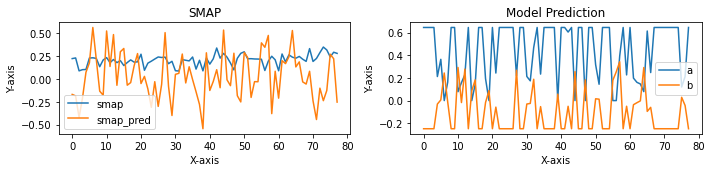

Epoch [16/5000] (LR: 0.0005):
Train loss: 0.5862 || Train physical loss: 0.0939 || Train similarity loss: 0.4923
Valid loss: 0.9349 || Valid physical loss: 0.0962 || Valid similarity loss: 0.8387


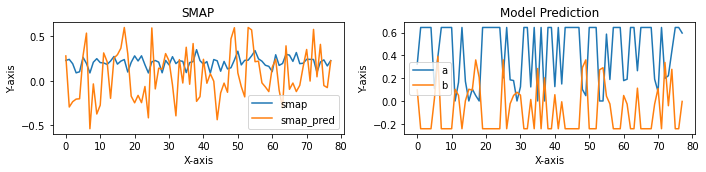

Epoch [17/5000] (LR: 0.0005):
Train loss: 0.5873 || Train physical loss: 0.0921 || Train similarity loss: 0.4952
Valid loss: 0.9202 || Valid physical loss: 0.0988 || Valid similarity loss: 0.8214


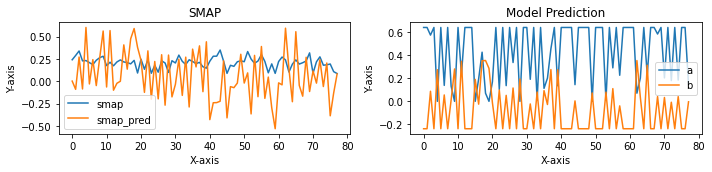

Epoch [18/5000] (LR: 0.0005):
Train loss: 0.7417 || Train physical loss: 0.0869 || Train similarity loss: 0.6548
Valid loss: 0.9198 || Valid physical loss: 0.0946 || Valid similarity loss: 0.8252


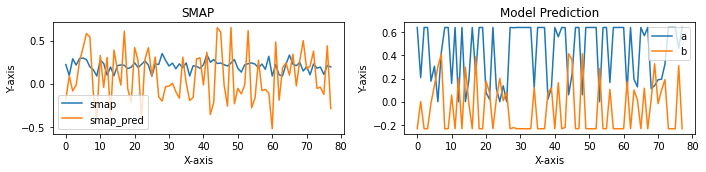

Epoch [19/5000] (LR: 0.0005):
Train loss: 0.4230 || Train physical loss: 0.0962 || Train similarity loss: 0.3269
Valid loss: 0.9102 || Valid physical loss: 0.0975 || Valid similarity loss: 0.8127
Saving model with loss 0.910...
D:\1GRADUATED\paper\downscaling_data\Soil_moisture_downscale_czt\DATASET\AB\OUTPUT\MODELS\CNN_FROM_UPSCALING\first.ckpt


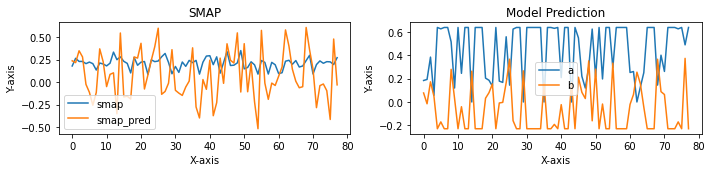

Epoch [20/5000] (LR: 0.0005):
Train loss: 0.7335 || Train physical loss: 0.0873 || Train similarity loss: 0.6462
Valid loss: 8.9392 || Valid physical loss: 0.0868 || Valid similarity loss: 8.8525


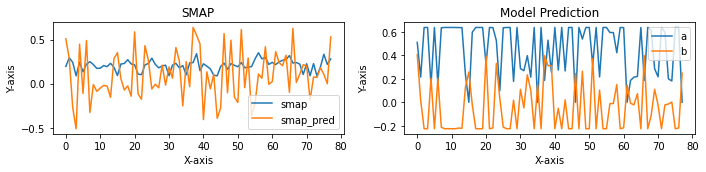

Epoch [21/5000] (LR: 0.0005):
Train loss: 0.5690 || Train physical loss: 0.0834 || Train similarity loss: 0.4856
Valid loss: 8.9978 || Valid physical loss: 0.0825 || Valid similarity loss: 8.9153


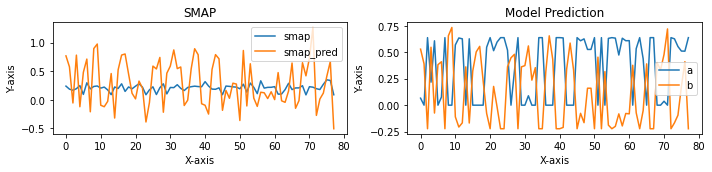

Epoch [22/5000] (LR: 0.0005):
Train loss: 2.0393 || Train physical loss: 0.1032 || Train similarity loss: 1.9361
Valid loss: 0.1590 || Valid physical loss: 0.1590 || Valid similarity loss: 0.0000
Saving model with loss 0.159...
D:\1GRADUATED\paper\downscaling_data\Soil_moisture_downscale_czt\DATASET\AB\OUTPUT\MODELS\CNN_FROM_UPSCALING\first.ckpt


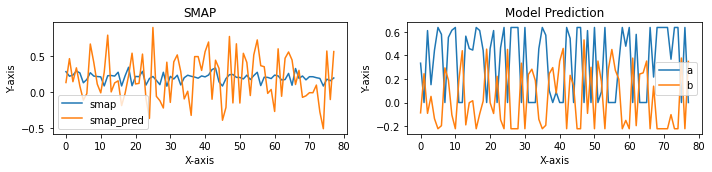

Epoch [23/5000] (LR: 0.0005):
Train loss: 0.1544 || Train physical loss: 0.1544 || Train similarity loss: 0.0000
Valid loss: 0.1013 || Valid physical loss: 0.1013 || Valid similarity loss: 0.0000
Saving model with loss 0.101...
D:\1GRADUATED\paper\downscaling_data\Soil_moisture_downscale_czt\DATASET\AB\OUTPUT\MODELS\CNN_FROM_UPSCALING\first.ckpt


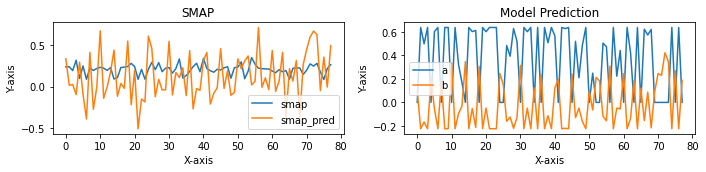

Epoch [24/5000] (LR: 0.0005):
Train loss: 0.5786 || Train physical loss: 0.0965 || Train similarity loss: 0.4821
Valid loss: 0.8991 || Valid physical loss: 0.0832 || Valid similarity loss: 0.8160


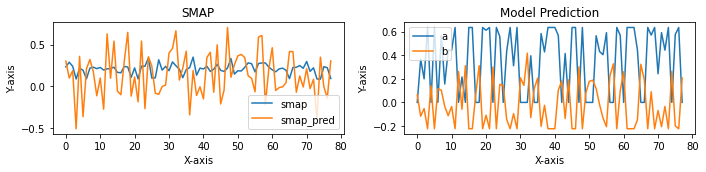

Epoch [25/5000] (LR: 0.0005):
Train loss: 0.8930 || Train physical loss: 0.0789 || Train similarity loss: 0.8142
Valid loss: 0.8931 || Valid physical loss: 0.0749 || Valid similarity loss: 0.8182


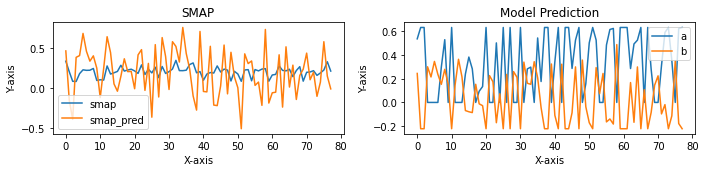

Epoch [26/5000] (LR: 0.0005):
Train loss: 0.8864 || Train physical loss: 0.0763 || Train similarity loss: 0.8101
Valid loss: 0.8804 || Valid physical loss: 0.0795 || Valid similarity loss: 0.8009


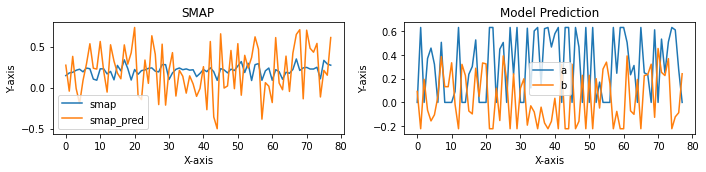

Epoch [27/5000] (LR: 0.0005):
Train loss: 0.4050 || Train physical loss: 0.0805 || Train similarity loss: 0.3245
Valid loss: 0.0786 || Valid physical loss: 0.0786 || Valid similarity loss: 0.0000
Saving model with loss 0.079...
D:\1GRADUATED\paper\downscaling_data\Soil_moisture_downscale_czt\DATASET\AB\OUTPUT\MODELS\CNN_FROM_UPSCALING\first.ckpt


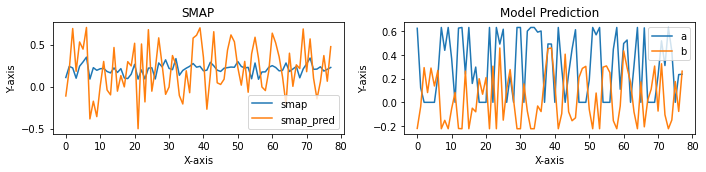

Epoch [28/5000] (LR: 0.0005):
Train loss: 0.7194 || Train physical loss: 0.0759 || Train similarity loss: 0.6434
Valid loss: 0.8774 || Valid physical loss: 0.0764 || Valid similarity loss: 0.8011


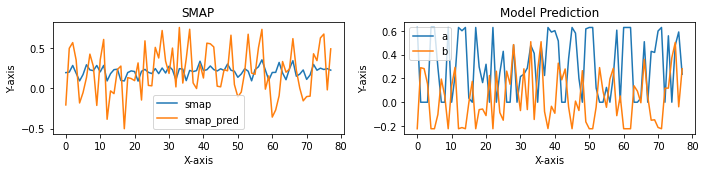

Epoch [29/5000] (LR: 0.0005):
Train loss: 0.7191 || Train physical loss: 0.0737 || Train similarity loss: 0.6454
Valid loss: 0.8768 || Valid physical loss: 0.0757 || Valid similarity loss: 0.8011


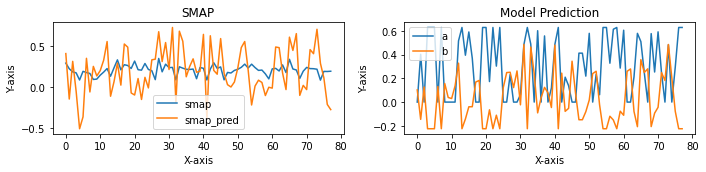

Epoch [30/5000] (LR: 0.0005):
Train loss: 0.5586 || Train physical loss: 0.0707 || Train similarity loss: 0.4879
Valid loss: 0.8780 || Valid physical loss: 0.0705 || Valid similarity loss: 0.8074


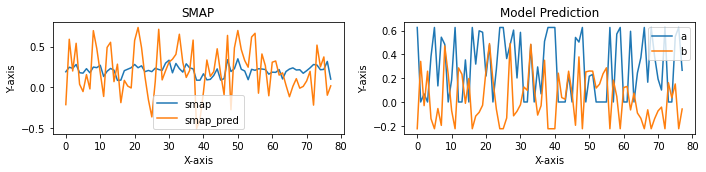

Epoch [31/5000] (LR: 0.0005):
Train loss: 0.8787 || Train physical loss: 0.0640 || Train similarity loss: 0.8147
Valid loss: 0.8774 || Valid physical loss: 0.0703 || Valid similarity loss: 0.8071


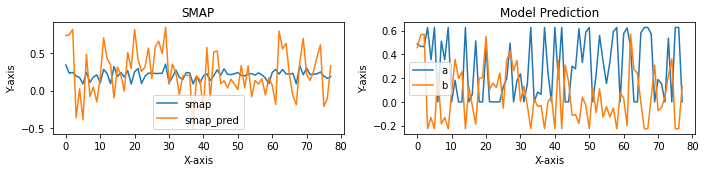

Epoch [32/5000] (LR: 0.0005):
Train loss: 0.8765 || Train physical loss: 0.0650 || Train similarity loss: 0.8115
Valid loss: 0.0802 || Valid physical loss: 0.0802 || Valid similarity loss: 0.0000


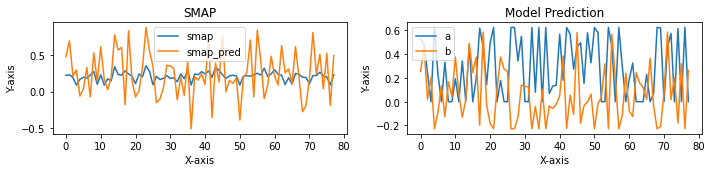

Epoch [33/5000] (LR: 0.0005):
Train loss: 0.7159 || Train physical loss: 0.0731 || Train similarity loss: 0.6428
Valid loss: 0.0838 || Valid physical loss: 0.0838 || Valid similarity loss: 0.0000


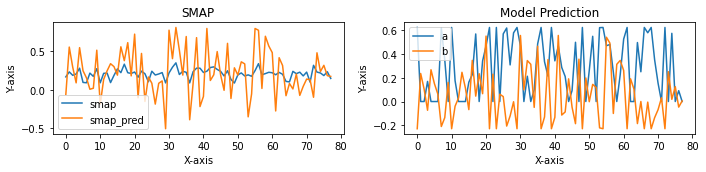

Epoch [34/5000] (LR: 0.0005):
Train loss: 0.8746 || Train physical loss: 0.0705 || Train similarity loss: 0.8041
Valid loss: 0.0802 || Valid physical loss: 0.0802 || Valid similarity loss: 0.0000


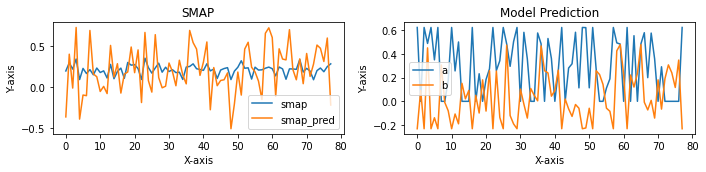

Epoch [35/5000] (LR: 0.0005):
Train loss: 0.7147 || Train physical loss: 0.0643 || Train similarity loss: 0.6504
Valid loss: 0.8753 || Valid physical loss: 0.0711 || Valid similarity loss: 0.8042


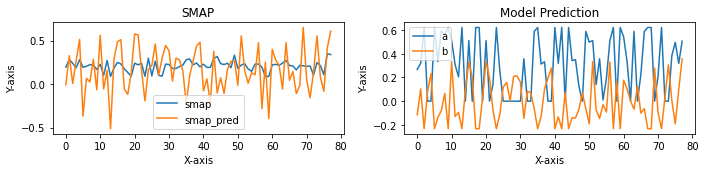

Epoch [36/5000] (LR: 0.0005):
Train loss: 0.0571 || Train physical loss: 0.0571 || Train similarity loss: 0.0000
Valid loss: 0.0586 || Valid physical loss: 0.0586 || Valid similarity loss: 0.0000
Saving model with loss 0.059...
D:\1GRADUATED\paper\downscaling_data\Soil_moisture_downscale_czt\DATASET\AB\OUTPUT\MODELS\CNN_FROM_UPSCALING\first.ckpt


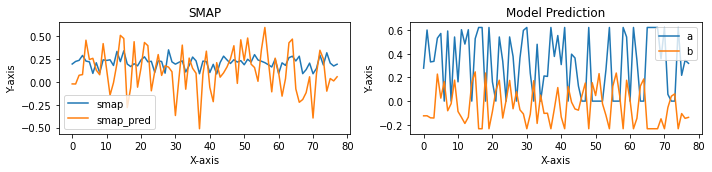

Epoch [37/5000] (LR: 0.0005):
Train loss: 0.0475 || Train physical loss: 0.0475 || Train similarity loss: 0.0000
Valid loss: 0.0525 || Valid physical loss: 0.0525 || Valid similarity loss: 0.0000
Saving model with loss 0.053...
D:\1GRADUATED\paper\downscaling_data\Soil_moisture_downscale_czt\DATASET\AB\OUTPUT\MODELS\CNN_FROM_UPSCALING\first.ckpt


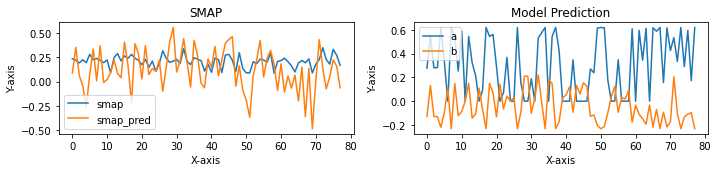

Epoch [38/5000] (LR: 0.0005):
Train loss: 0.0413 || Train physical loss: 0.0413 || Train similarity loss: 0.0000
Valid loss: 0.0459 || Valid physical loss: 0.0459 || Valid similarity loss: 0.0000
Saving model with loss 0.046...
D:\1GRADUATED\paper\downscaling_data\Soil_moisture_downscale_czt\DATASET\AB\OUTPUT\MODELS\CNN_FROM_UPSCALING\first.ckpt


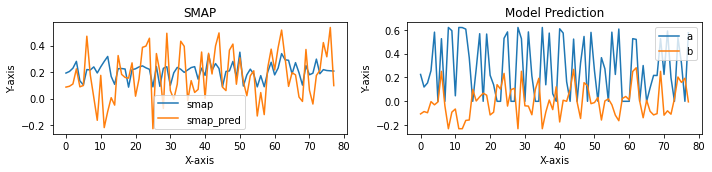

Epoch [39/5000] (LR: 0.0005):
Train loss: 0.0311 || Train physical loss: 0.0311 || Train similarity loss: 0.0000
Valid loss: 0.0286 || Valid physical loss: 0.0286 || Valid similarity loss: 0.0000
Saving model with loss 0.029...
D:\1GRADUATED\paper\downscaling_data\Soil_moisture_downscale_czt\DATASET\AB\OUTPUT\MODELS\CNN_FROM_UPSCALING\first.ckpt


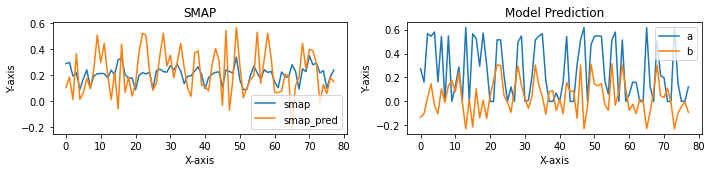

Epoch [40/5000] (LR: 0.0005):
Train loss: 0.0266 || Train physical loss: 0.0266 || Train similarity loss: 0.0000
Valid loss: 0.0253 || Valid physical loss: 0.0253 || Valid similarity loss: 0.0000
Saving model with loss 0.025...
D:\1GRADUATED\paper\downscaling_data\Soil_moisture_downscale_czt\DATASET\AB\OUTPUT\MODELS\CNN_FROM_UPSCALING\first.ckpt


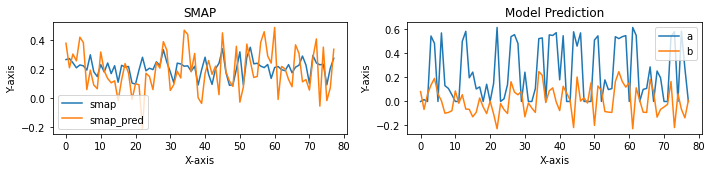

Epoch [41/5000] (LR: 0.0005):
Train loss: 0.0192 || Train physical loss: 0.0192 || Train similarity loss: 0.0000
Valid loss: 0.0187 || Valid physical loss: 0.0187 || Valid similarity loss: 0.0000
Saving model with loss 0.019...
D:\1GRADUATED\paper\downscaling_data\Soil_moisture_downscale_czt\DATASET\AB\OUTPUT\MODELS\CNN_FROM_UPSCALING\first.ckpt


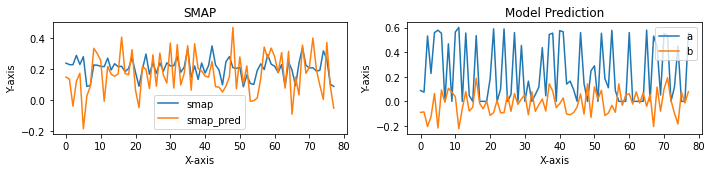

Epoch [42/5000] (LR: 0.0005):
Train loss: 0.0146 || Train physical loss: 0.0146 || Train similarity loss: 0.0000
Valid loss: 0.0158 || Valid physical loss: 0.0158 || Valid similarity loss: 0.0000
Saving model with loss 0.016...
D:\1GRADUATED\paper\downscaling_data\Soil_moisture_downscale_czt\DATASET\AB\OUTPUT\MODELS\CNN_FROM_UPSCALING\first.ckpt


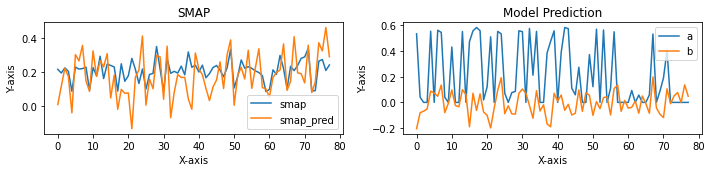

Epoch [43/5000] (LR: 0.0005):
Train loss: 0.0132 || Train physical loss: 0.0132 || Train similarity loss: 0.0000
Valid loss: 0.0128 || Valid physical loss: 0.0128 || Valid similarity loss: 0.0000
Saving model with loss 0.013...
D:\1GRADUATED\paper\downscaling_data\Soil_moisture_downscale_czt\DATASET\AB\OUTPUT\MODELS\CNN_FROM_UPSCALING\first.ckpt


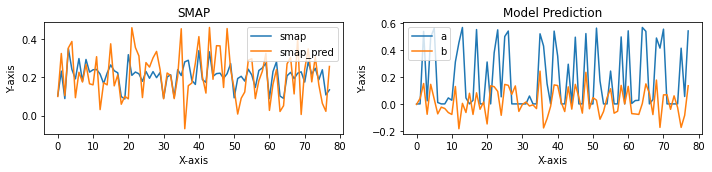

Epoch [44/5000] (LR: 0.0005):
Train loss: 0.0101 || Train physical loss: 0.0101 || Train similarity loss: 0.0000
Valid loss: 0.0114 || Valid physical loss: 0.0114 || Valid similarity loss: 0.0000
Saving model with loss 0.011...
D:\1GRADUATED\paper\downscaling_data\Soil_moisture_downscale_czt\DATASET\AB\OUTPUT\MODELS\CNN_FROM_UPSCALING\first.ckpt


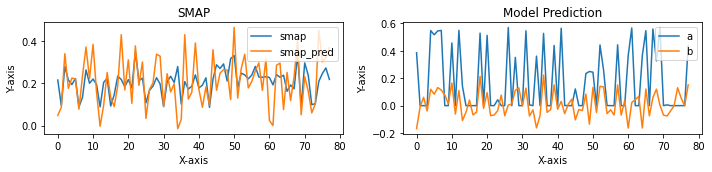

Epoch [45/5000] (LR: 0.0005):
Train loss: 0.0090 || Train physical loss: 0.0090 || Train similarity loss: 0.0000
Valid loss: 0.0098 || Valid physical loss: 0.0098 || Valid similarity loss: 0.0000
Saving model with loss 0.010...
D:\1GRADUATED\paper\downscaling_data\Soil_moisture_downscale_czt\DATASET\AB\OUTPUT\MODELS\CNN_FROM_UPSCALING\first.ckpt


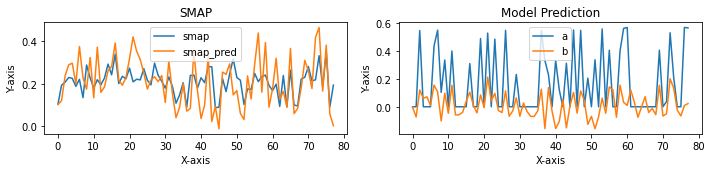

Epoch [46/5000] (LR: 0.0005):
Train loss: 0.1934 || Train physical loss: 0.0073 || Train similarity loss: 0.1860
Valid loss: 0.0089 || Valid physical loss: 0.0089 || Valid similarity loss: 0.0000
Saving model with loss 0.009...
D:\1GRADUATED\paper\downscaling_data\Soil_moisture_downscale_czt\DATASET\AB\OUTPUT\MODELS\CNN_FROM_UPSCALING\first.ckpt


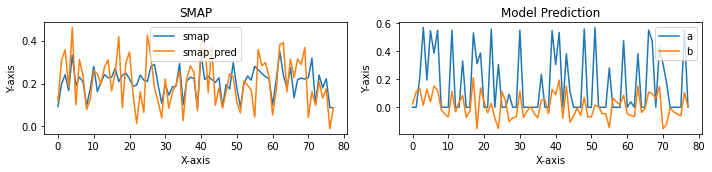

Epoch [47/5000] (LR: 0.0005):
Train loss: 0.0067 || Train physical loss: 0.0067 || Train similarity loss: 0.0000
Valid loss: 0.0082 || Valid physical loss: 0.0082 || Valid similarity loss: 0.0000
Saving model with loss 0.008...
D:\1GRADUATED\paper\downscaling_data\Soil_moisture_downscale_czt\DATASET\AB\OUTPUT\MODELS\CNN_FROM_UPSCALING\first.ckpt


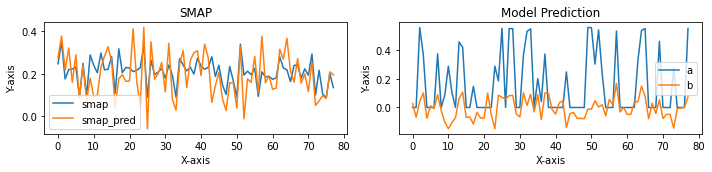

Epoch [48/5000] (LR: 0.0005):
Train loss: 0.0058 || Train physical loss: 0.0058 || Train similarity loss: 0.0000
Valid loss: 0.0068 || Valid physical loss: 0.0068 || Valid similarity loss: 0.0000
Saving model with loss 0.007...
D:\1GRADUATED\paper\downscaling_data\Soil_moisture_downscale_czt\DATASET\AB\OUTPUT\MODELS\CNN_FROM_UPSCALING\first.ckpt


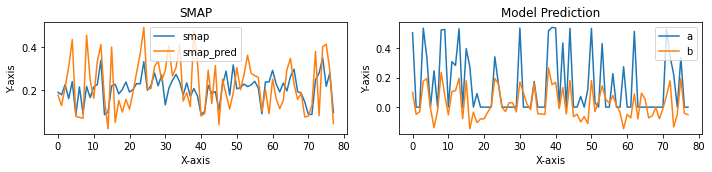

Epoch [49/5000] (LR: 0.0005):
Train loss: 0.3776 || Train physical loss: 0.0052 || Train similarity loss: 0.3724
Valid loss: 0.0100 || Valid physical loss: 0.0100 || Valid similarity loss: 0.0000


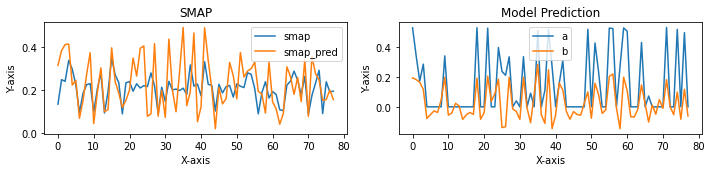

Epoch [50/5000] (LR: 0.0005):
Train loss: 0.0097 || Train physical loss: 0.0097 || Train similarity loss: 0.0000
Valid loss: 0.0111 || Valid physical loss: 0.0111 || Valid similarity loss: 0.0000


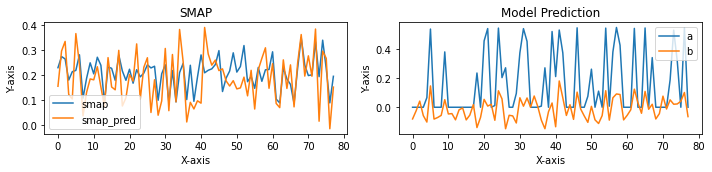

Epoch [51/5000] (LR: 0.0005):
Train loss: 0.1938 || Train physical loss: 0.0072 || Train similarity loss: 0.1865
Valid loss: 0.0063 || Valid physical loss: 0.0063 || Valid similarity loss: 0.0000
Saving model with loss 0.006...
D:\1GRADUATED\paper\downscaling_data\Soil_moisture_downscale_czt\DATASET\AB\OUTPUT\MODELS\CNN_FROM_UPSCALING\first.ckpt


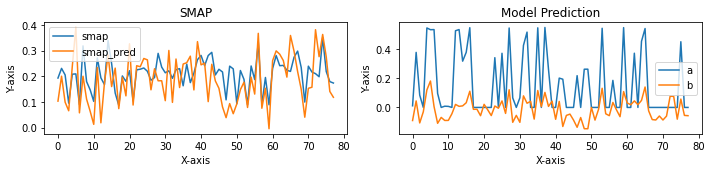

Epoch [52/5000] (LR: 0.0005):
Train loss: 0.0053 || Train physical loss: 0.0053 || Train similarity loss: 0.0000
Valid loss: 0.0061 || Valid physical loss: 0.0061 || Valid similarity loss: 0.0000
Saving model with loss 0.006...
D:\1GRADUATED\paper\downscaling_data\Soil_moisture_downscale_czt\DATASET\AB\OUTPUT\MODELS\CNN_FROM_UPSCALING\first.ckpt


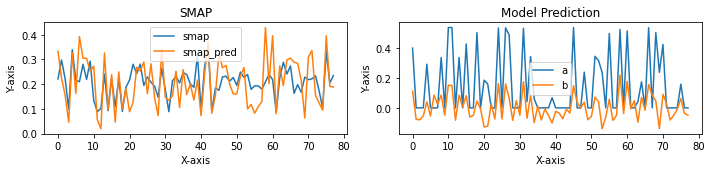

Epoch [53/5000] (LR: 0.0005):
Train loss: 0.1924 || Train physical loss: 0.0049 || Train similarity loss: 0.1875
Valid loss: 0.0063 || Valid physical loss: 0.0063 || Valid similarity loss: 0.0000


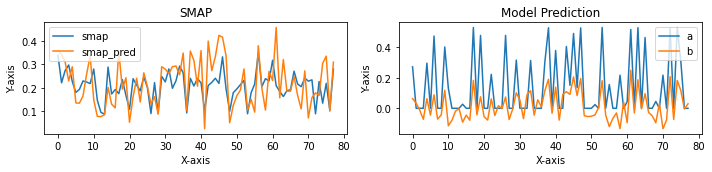

Epoch [54/5000] (LR: 0.0005):
Train loss: 0.0058 || Train physical loss: 0.0058 || Train similarity loss: 0.0000
Valid loss: 0.0075 || Valid physical loss: 0.0075 || Valid similarity loss: 0.0000


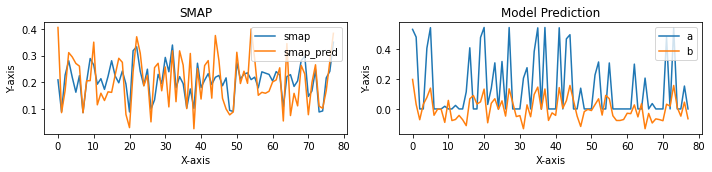

Epoch [55/5000] (LR: 0.0005):
Train loss: 0.1932 || Train physical loss: 0.0053 || Train similarity loss: 0.1879
Valid loss: 0.0052 || Valid physical loss: 0.0052 || Valid similarity loss: 0.0000
Saving model with loss 0.005...
D:\1GRADUATED\paper\downscaling_data\Soil_moisture_downscale_czt\DATASET\AB\OUTPUT\MODELS\CNN_FROM_UPSCALING\first.ckpt


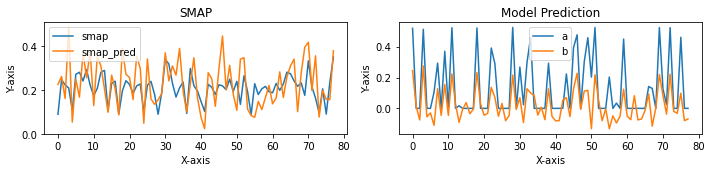

Epoch [56/5000] (LR: 0.0005):
Train loss: 0.1921 || Train physical loss: 0.0058 || Train similarity loss: 0.1863
Valid loss: 0.0090 || Valid physical loss: 0.0090 || Valid similarity loss: 0.0000


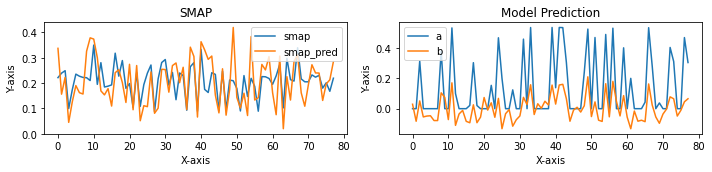

Epoch [57/5000] (LR: 0.0005):
Train loss: 0.0064 || Train physical loss: 0.0064 || Train similarity loss: 0.0000
Valid loss: 0.0056 || Valid physical loss: 0.0056 || Valid similarity loss: 0.0000


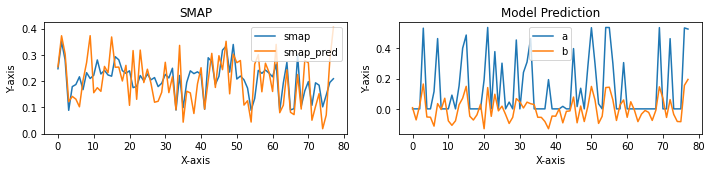

Epoch [58/5000] (LR: 0.0005):
Train loss: 0.1909 || Train physical loss: 0.0044 || Train similarity loss: 0.1865
Valid loss: 0.0052 || Valid physical loss: 0.0052 || Valid similarity loss: 0.0000
Saving model with loss 0.005...
D:\1GRADUATED\paper\downscaling_data\Soil_moisture_downscale_czt\DATASET\AB\OUTPUT\MODELS\CNN_FROM_UPSCALING\first.ckpt


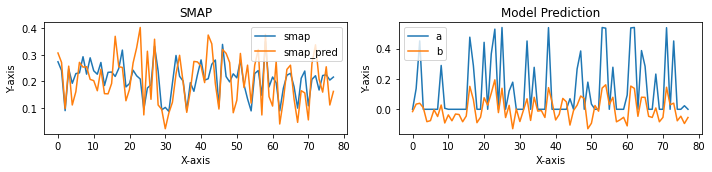

Epoch [59/5000] (LR: 0.0005):
Train loss: 0.0046 || Train physical loss: 0.0046 || Train similarity loss: 0.0000
Valid loss: 0.0050 || Valid physical loss: 0.0050 || Valid similarity loss: 0.0000
Saving model with loss 0.005...
D:\1GRADUATED\paper\downscaling_data\Soil_moisture_downscale_czt\DATASET\AB\OUTPUT\MODELS\CNN_FROM_UPSCALING\first.ckpt


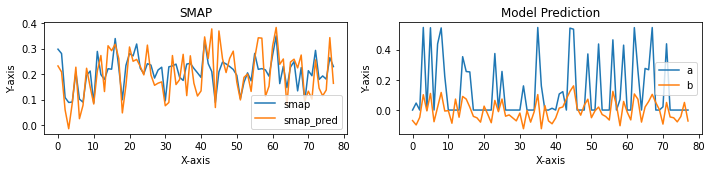

Epoch [60/5000] (LR: 0.0005):
Train loss: 0.0038 || Train physical loss: 0.0038 || Train similarity loss: 0.0000
Valid loss: 0.0042 || Valid physical loss: 0.0042 || Valid similarity loss: 0.0000
Saving model with loss 0.004...
D:\1GRADUATED\paper\downscaling_data\Soil_moisture_downscale_czt\DATASET\AB\OUTPUT\MODELS\CNN_FROM_UPSCALING\first.ckpt


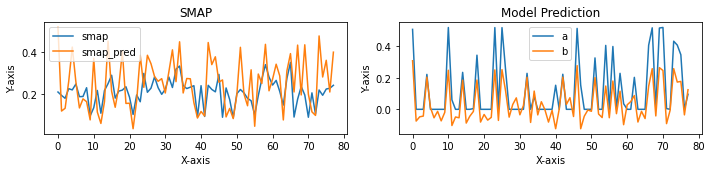

Epoch [61/5000] (LR: 0.0005):
Train loss: 0.5661 || Train physical loss: 0.0045 || Train similarity loss: 0.5616
Valid loss: 0.0132 || Valid physical loss: 0.0132 || Valid similarity loss: 0.0000


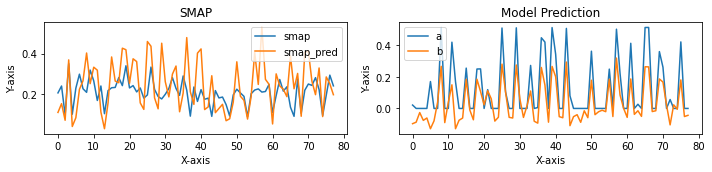

Epoch [62/5000] (LR: 0.0005):
Train loss: 0.0148 || Train physical loss: 0.0148 || Train similarity loss: 0.0000
Valid loss: 0.0137 || Valid physical loss: 0.0137 || Valid similarity loss: 0.0000


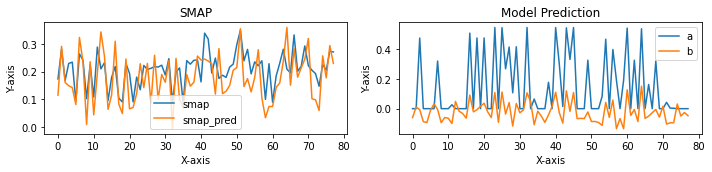

Epoch [63/5000] (LR: 0.0005):
Train loss: 0.0073 || Train physical loss: 0.0073 || Train similarity loss: 0.0000
Valid loss: 0.0053 || Valid physical loss: 0.0053 || Valid similarity loss: 0.0000


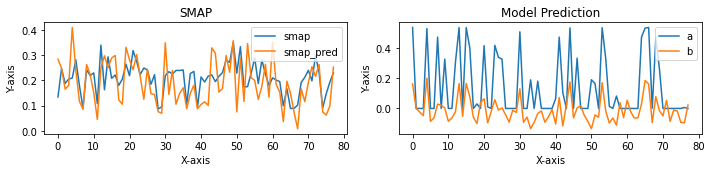

Epoch [64/5000] (LR: 0.0005):
Train loss: 0.5677 || Train physical loss: 0.0064 || Train similarity loss: 0.5613
Valid loss: 0.0060 || Valid physical loss: 0.0060 || Valid similarity loss: 0.0000


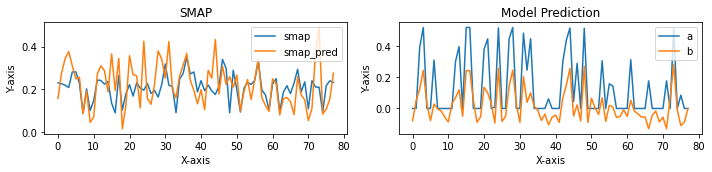

Epoch [65/5000] (LR: 0.0005):
Train loss: 0.0066 || Train physical loss: 0.0066 || Train similarity loss: 0.0000
Valid loss: 0.0090 || Valid physical loss: 0.0090 || Valid similarity loss: 0.0000


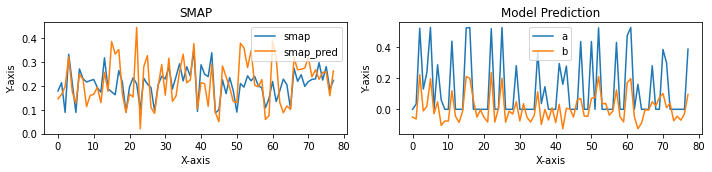

Epoch [66/5000] (LR: 0.0005):
Train loss: 0.0072 || Train physical loss: 0.0072 || Train similarity loss: 0.0000
Valid loss: 0.0065 || Valid physical loss: 0.0065 || Valid similarity loss: 0.0000


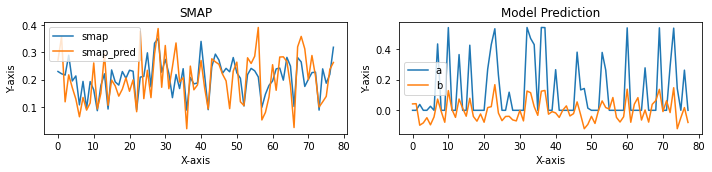

Epoch [67/5000] (LR: 0.0005):
Train loss: 0.1909 || Train physical loss: 0.0049 || Train similarity loss: 0.1860
Valid loss: 0.0044 || Valid physical loss: 0.0044 || Valid similarity loss: 0.0000


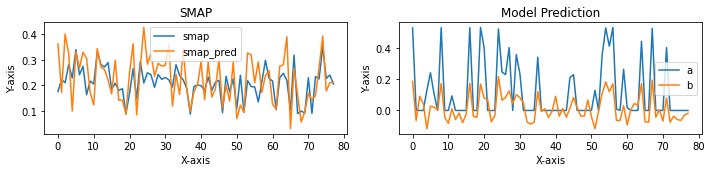

Epoch [68/5000] (LR: 0.0005):
Train loss: 0.1906 || Train physical loss: 0.0042 || Train similarity loss: 0.1865
Valid loss: 0.0058 || Valid physical loss: 0.0058 || Valid similarity loss: 0.0000


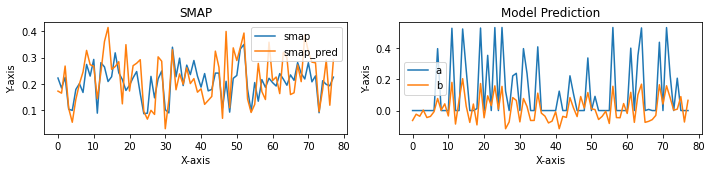

Epoch [69/5000] (LR: 0.0005):
Train loss: 0.0051 || Train physical loss: 0.0051 || Train similarity loss: 0.0000
Valid loss: 0.0054 || Valid physical loss: 0.0054 || Valid similarity loss: 0.0000


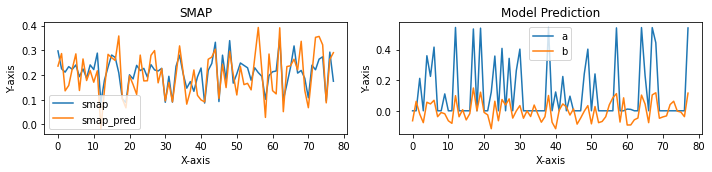

Epoch [70/5000] (LR: 0.0005):
Train loss: 0.0040 || Train physical loss: 0.0040 || Train similarity loss: 0.0000
Valid loss: 0.0039 || Valid physical loss: 0.0039 || Valid similarity loss: 0.0000
Saving model with loss 0.004...
D:\1GRADUATED\paper\downscaling_data\Soil_moisture_downscale_czt\DATASET\AB\OUTPUT\MODELS\CNN_FROM_UPSCALING\first.ckpt


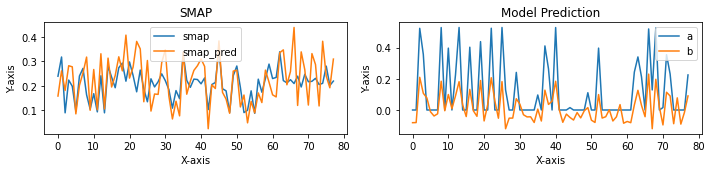

Epoch [71/5000] (LR: 0.0005):
Train loss: 0.3769 || Train physical loss: 0.0043 || Train similarity loss: 0.3726
Valid loss: 0.0064 || Valid physical loss: 0.0064 || Valid similarity loss: 0.0000


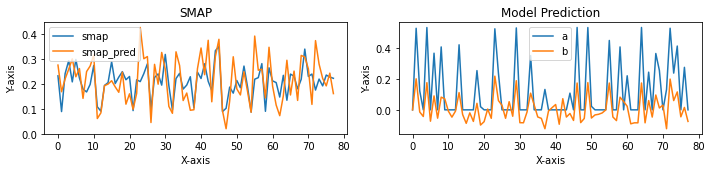

Epoch [72/5000] (LR: 0.0005):
Train loss: 0.0056 || Train physical loss: 0.0056 || Train similarity loss: 0.0000
Valid loss: 0.0057 || Valid physical loss: 0.0057 || Valid similarity loss: 0.0000


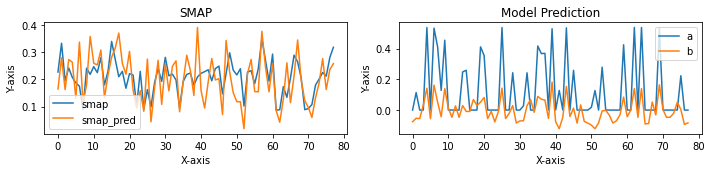

Epoch [73/5000] (LR: 0.0005):
Train loss: 0.1911 || Train physical loss: 0.0045 || Train similarity loss: 0.1866
Valid loss: 0.0046 || Valid physical loss: 0.0046 || Valid similarity loss: 0.0000


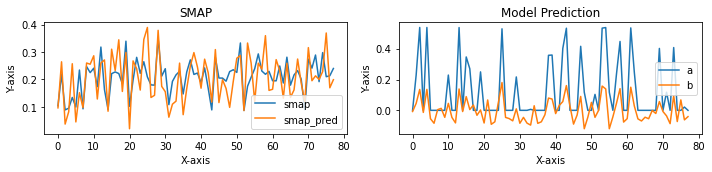

Epoch [74/5000] (LR: 0.0005):
Train loss: 0.0041 || Train physical loss: 0.0041 || Train similarity loss: 0.0000
Valid loss: 0.0045 || Valid physical loss: 0.0045 || Valid similarity loss: 0.0000


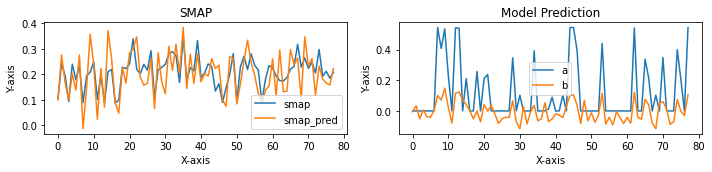

Epoch [75/5000] (LR: 0.0005):
Train loss: 0.0040 || Train physical loss: 0.0040 || Train similarity loss: 0.0000
Valid loss: 0.0038 || Valid physical loss: 0.0038 || Valid similarity loss: 0.0000
Saving model with loss 0.004...
D:\1GRADUATED\paper\downscaling_data\Soil_moisture_downscale_czt\DATASET\AB\OUTPUT\MODELS\CNN_FROM_UPSCALING\first.ckpt


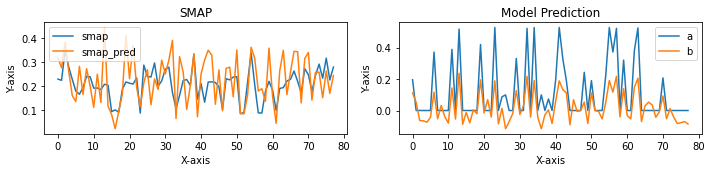

Epoch [76/5000] (LR: 0.0005):
Train loss: 0.3765 || Train physical loss: 0.0037 || Train similarity loss: 0.3728
Valid loss: 0.0071 || Valid physical loss: 0.0071 || Valid similarity loss: 0.0000


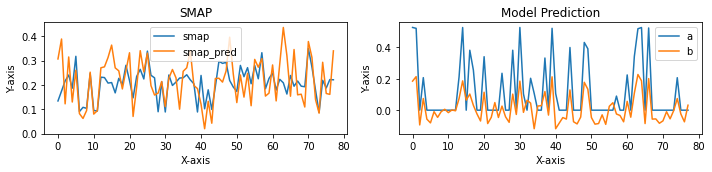

Epoch [77/5000] (LR: 0.0005):
Train loss: 0.0064 || Train physical loss: 0.0064 || Train similarity loss: 0.0000
Valid loss: 0.0063 || Valid physical loss: 0.0063 || Valid similarity loss: 0.0000


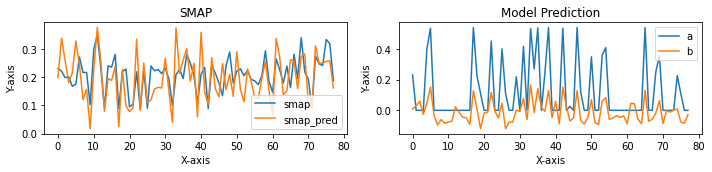

Epoch [78/5000] (LR: 0.0005):
Train loss: 0.1908 || Train physical loss: 0.0048 || Train similarity loss: 0.1860
Valid loss: 0.0043 || Valid physical loss: 0.0043 || Valid similarity loss: 0.0000


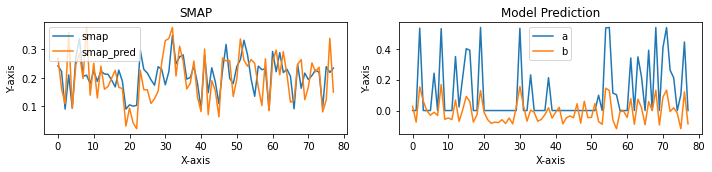

Epoch [79/5000] (LR: 0.0005):
Train loss: 0.0041 || Train physical loss: 0.0041 || Train similarity loss: 0.0000
Valid loss: 0.0043 || Valid physical loss: 0.0043 || Valid similarity loss: 0.0000


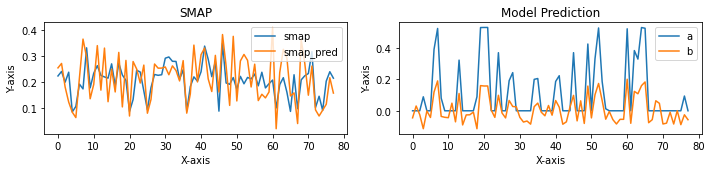

Epoch [80/5000] (LR: 0.0005):
Train loss: 0.1900 || Train physical loss: 0.0040 || Train similarity loss: 0.1861
Valid loss: 0.0053 || Valid physical loss: 0.0053 || Valid similarity loss: 0.0000


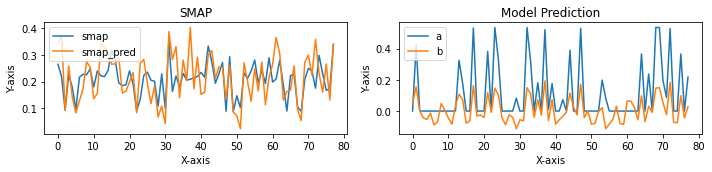

Epoch [81/5000] (LR: 0.0005):
Train loss: 0.0048 || Train physical loss: 0.0048 || Train similarity loss: 0.0000
Valid loss: 0.0050 || Valid physical loss: 0.0050 || Valid similarity loss: 0.0000


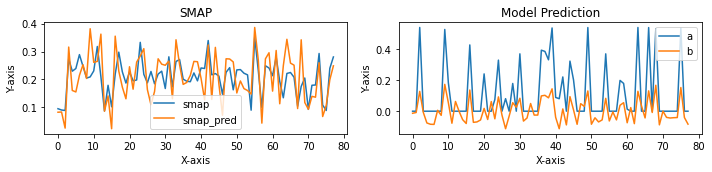

Epoch [82/5000] (LR: 0.0005):
Train loss: 0.1900 || Train physical loss: 0.0038 || Train similarity loss: 0.1862
Valid loss: 0.0043 || Valid physical loss: 0.0043 || Valid similarity loss: 0.0000


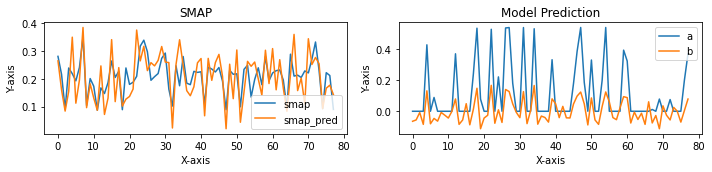

Epoch [83/5000] (LR: 0.0005):
Train loss: 0.0037 || Train physical loss: 0.0037 || Train similarity loss: 0.0000
Valid loss: 0.0042 || Valid physical loss: 0.0042 || Valid similarity loss: 0.0000


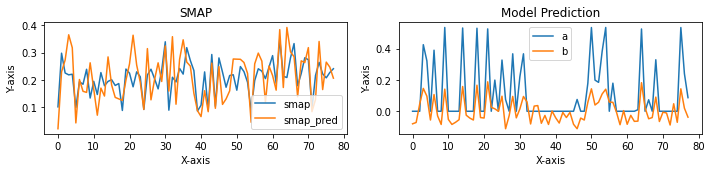

Epoch [84/5000] (LR: 0.0005):
Train loss: 0.3761 || Train physical loss: 0.0037 || Train similarity loss: 0.3725
Valid loss: 0.0047 || Valid physical loss: 0.0047 || Valid similarity loss: 0.0000


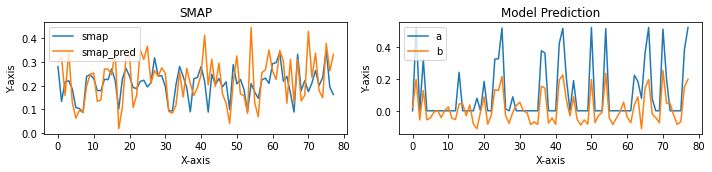

Epoch [85/5000] (LR: 0.0005):
Train loss: 0.0054 || Train physical loss: 0.0054 || Train similarity loss: 0.0000
Valid loss: 0.0074 || Valid physical loss: 0.0074 || Valid similarity loss: 0.0000


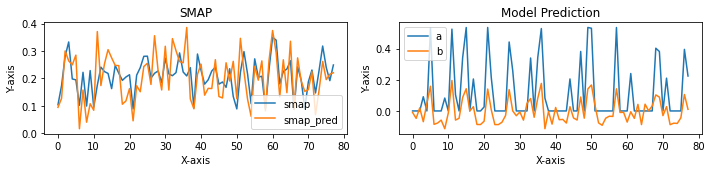

Epoch [86/5000] (LR: 0.0005):
Train loss: 0.0054 || Train physical loss: 0.0054 || Train similarity loss: 0.0000
Valid loss: 0.0047 || Valid physical loss: 0.0047 || Valid similarity loss: 0.0000


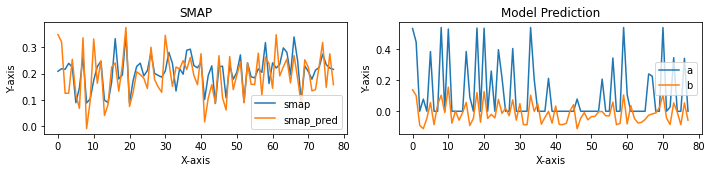

Epoch [87/5000] (LR: 0.00025):
Train loss: 0.0039 || Train physical loss: 0.0039 || Train similarity loss: 0.0000
Valid loss: 0.0041 || Valid physical loss: 0.0041 || Valid similarity loss: 0.0000


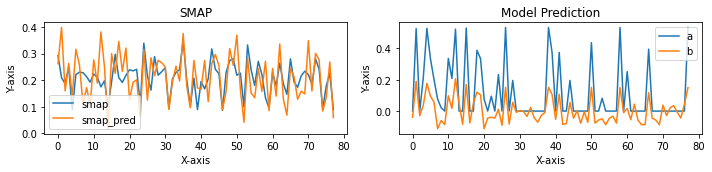

Epoch [88/5000] (LR: 0.00025):
Train loss: 0.3765 || Train physical loss: 0.0039 || Train similarity loss: 0.3726
Valid loss: 0.0051 || Valid physical loss: 0.0051 || Valid similarity loss: 0.0000


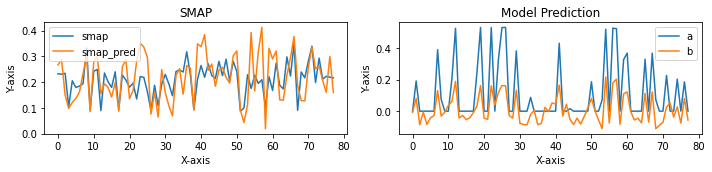

Epoch [89/5000] (LR: 0.00025):
Train loss: 0.0046 || Train physical loss: 0.0046 || Train similarity loss: 0.0000
Valid loss: 0.0057 || Valid physical loss: 0.0057 || Valid similarity loss: 0.0000


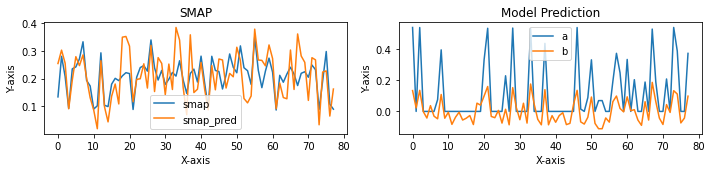

Epoch [90/5000] (LR: 0.00025):
Train loss: 0.0044 || Train physical loss: 0.0044 || Train similarity loss: 0.0000
Valid loss: 0.0046 || Valid physical loss: 0.0046 || Valid similarity loss: 0.0000


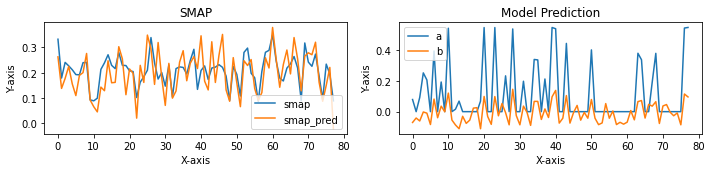

Epoch [91/5000] (LR: 0.00025):
Train loss: 0.0036 || Train physical loss: 0.0036 || Train similarity loss: 0.0000
Valid loss: 0.0038 || Valid physical loss: 0.0038 || Valid similarity loss: 0.0000
Saving model with loss 0.004...
D:\1GRADUATED\paper\downscaling_data\Soil_moisture_downscale_czt\DATASET\AB\OUTPUT\MODELS\CNN_FROM_UPSCALING\first.ckpt


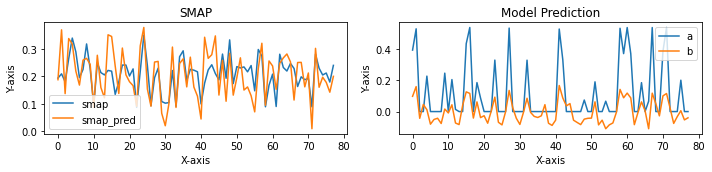

Epoch [92/5000] (LR: 0.00025):
Train loss: 0.3755 || Train physical loss: 0.0032 || Train similarity loss: 0.3723
Valid loss: 0.0042 || Valid physical loss: 0.0042 || Valid similarity loss: 0.0000


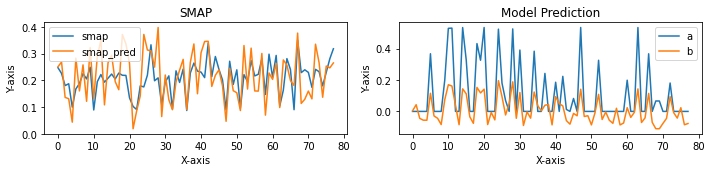

Epoch [93/5000] (LR: 0.00025):
Train loss: 0.0041 || Train physical loss: 0.0041 || Train similarity loss: 0.0000
Valid loss: 0.0053 || Valid physical loss: 0.0053 || Valid similarity loss: 0.0000


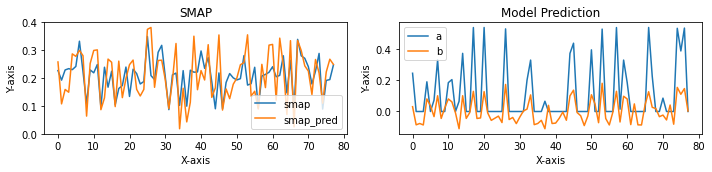

Epoch [94/5000] (LR: 0.00025):
Train loss: 0.0040 || Train physical loss: 0.0040 || Train similarity loss: 0.0000
Valid loss: 0.0046 || Valid physical loss: 0.0046 || Valid similarity loss: 0.0000


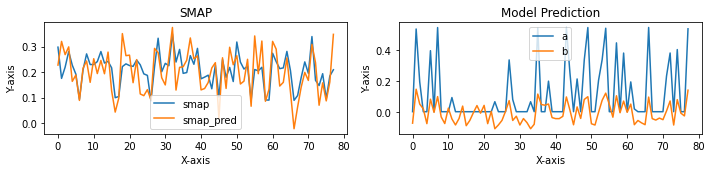

Epoch [95/5000] (LR: 0.00025):
Train loss: 0.0035 || Train physical loss: 0.0035 || Train similarity loss: 0.0000
Valid loss: 0.0038 || Valid physical loss: 0.0038 || Valid similarity loss: 0.0000


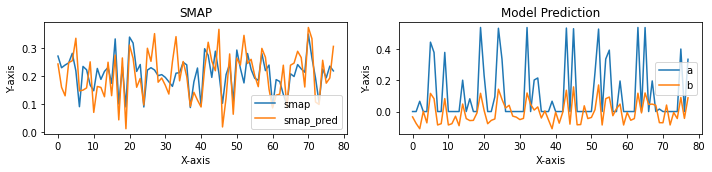

Epoch [96/5000] (LR: 0.00025):
Train loss: 0.3760 || Train physical loss: 0.0033 || Train similarity loss: 0.3727
Valid loss: 0.0041 || Valid physical loss: 0.0041 || Valid similarity loss: 0.0000


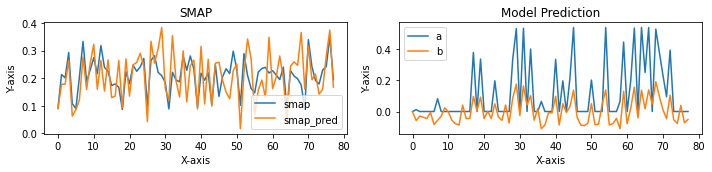

Epoch [97/5000] (LR: 0.00025):
Train loss: 0.0036 || Train physical loss: 0.0036 || Train similarity loss: 0.0000
Valid loss: 0.0045 || Valid physical loss: 0.0045 || Valid similarity loss: 0.0000


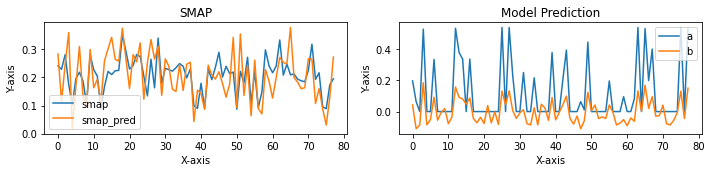

Epoch [98/5000] (LR: 0.000125):
Train loss: 0.0038 || Train physical loss: 0.0038 || Train similarity loss: 0.0000
Valid loss: 0.0043 || Valid physical loss: 0.0043 || Valid similarity loss: 0.0000


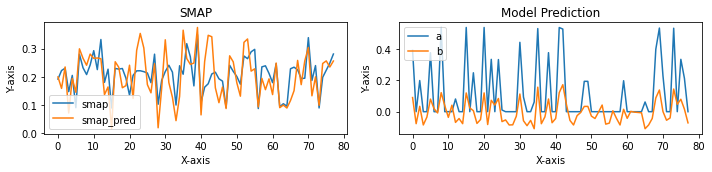

Epoch [99/5000] (LR: 0.000125):
Train loss: 0.0036 || Train physical loss: 0.0036 || Train similarity loss: 0.0000
Valid loss: 0.0040 || Valid physical loss: 0.0040 || Valid similarity loss: 0.0000


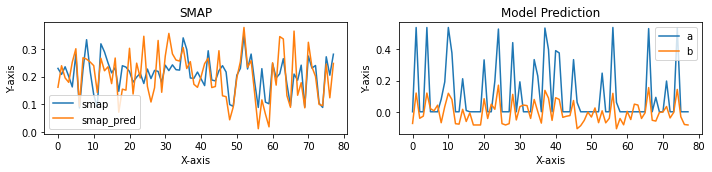

Epoch [100/5000] (LR: 0.000125):
Train loss: 0.3766 || Train physical loss: 0.0034 || Train similarity loss: 0.3732
Valid loss: 0.0040 || Valid physical loss: 0.0040 || Valid similarity loss: 0.0000


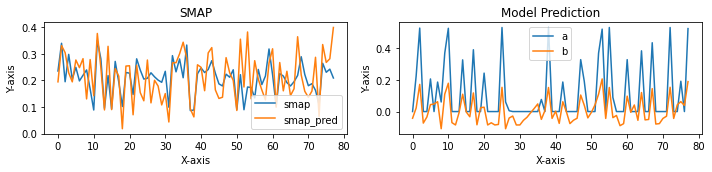

Epoch [101/5000] (LR: 0.000125):
Train loss: 0.1901 || Train physical loss: 0.0037 || Train similarity loss: 0.1865
Valid loss: 0.0051 || Valid physical loss: 0.0051 || Valid similarity loss: 0.0000


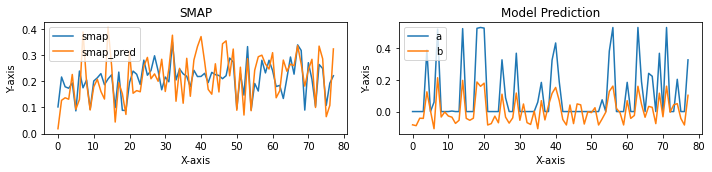

Epoch [102/5000] (LR: 0.000125):
Train loss: 0.0045 || Train physical loss: 0.0045 || Train similarity loss: 0.0000
Valid loss: 0.0054 || Valid physical loss: 0.0054 || Valid similarity loss: 0.0000


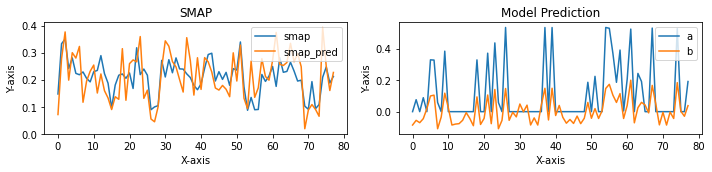

Epoch [103/5000] (LR: 0.000125):
Train loss: 0.0044 || Train physical loss: 0.0044 || Train similarity loss: 0.0000
Valid loss: 0.0048 || Valid physical loss: 0.0048 || Valid similarity loss: 0.0000


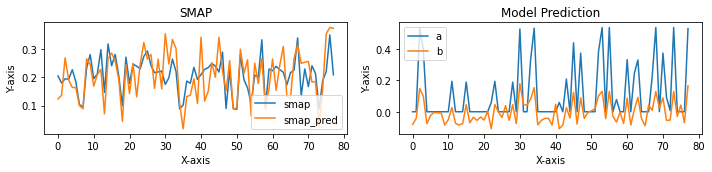

Epoch [104/5000] (LR: 0.000125):
Train loss: 0.0038 || Train physical loss: 0.0038 || Train similarity loss: 0.0000
Valid loss: 0.0042 || Valid physical loss: 0.0042 || Valid similarity loss: 0.0000


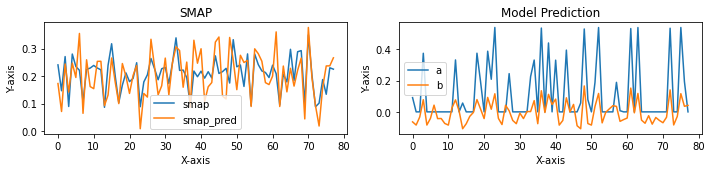

Epoch [105/5000] (LR: 0.000125):
Train loss: 0.1897 || Train physical loss: 0.0035 || Train similarity loss: 0.1862
Valid loss: 0.0039 || Valid physical loss: 0.0039 || Valid similarity loss: 0.0000


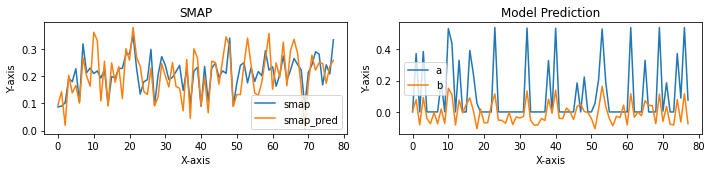

Epoch [106/5000] (LR: 0.000125):
Train loss: 0.0033 || Train physical loss: 0.0033 || Train similarity loss: 0.0000
Valid loss: 0.0039 || Valid physical loss: 0.0039 || Valid similarity loss: 0.0000


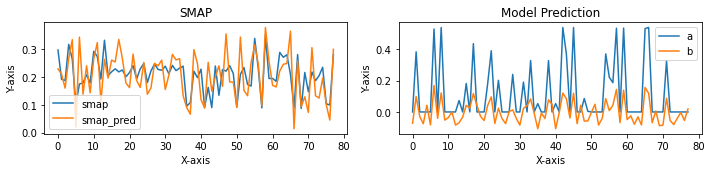

Epoch [107/5000] (LR: 0.000125):
Train loss: 0.1893 || Train physical loss: 0.0033 || Train similarity loss: 0.1860
Valid loss: 0.0040 || Valid physical loss: 0.0040 || Valid similarity loss: 0.0000


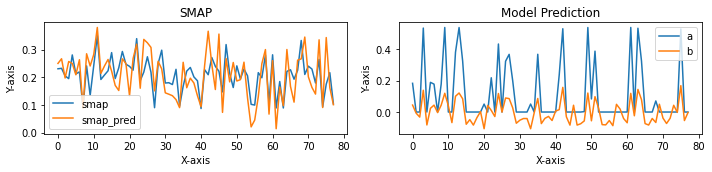

Epoch [108/5000] (LR: 0.000125):
Train loss: 0.0034 || Train physical loss: 0.0034 || Train similarity loss: 0.0000
Valid loss: 0.0040 || Valid physical loss: 0.0040 || Valid similarity loss: 0.0000


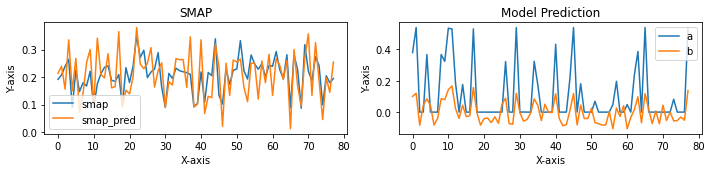

Epoch [109/5000] (LR: 6.25e-05):
Train loss: 0.1895 || Train physical loss: 0.0033 || Train similarity loss: 0.1862
Valid loss: 0.0039 || Valid physical loss: 0.0039 || Valid similarity loss: 0.0000


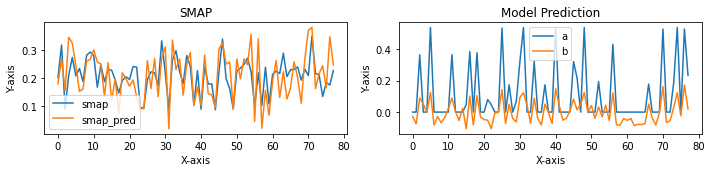

Epoch [110/5000] (LR: 6.25e-05):
Train loss: 0.0034 || Train physical loss: 0.0034 || Train similarity loss: 0.0000
Valid loss: 0.0041 || Valid physical loss: 0.0041 || Valid similarity loss: 0.0000


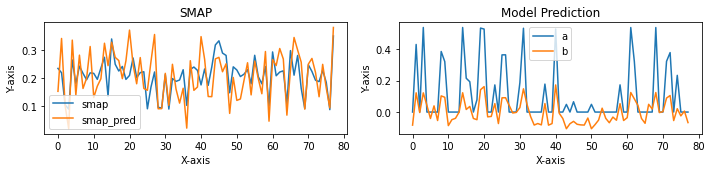

Epoch [111/5000] (LR: 6.25e-05):
Train loss: 0.0034 || Train physical loss: 0.0034 || Train similarity loss: 0.0000
Valid loss: 0.0041 || Valid physical loss: 0.0041 || Valid similarity loss: 0.0000


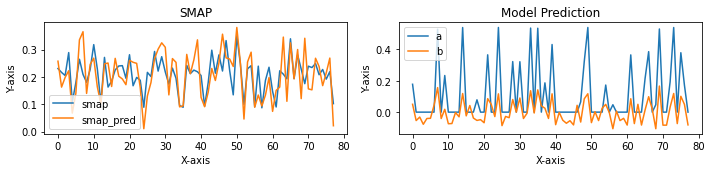

Epoch [112/5000] (LR: 6.25e-05):
Train loss: 0.0034 || Train physical loss: 0.0034 || Train similarity loss: 0.0000
Valid loss: 0.0039 || Valid physical loss: 0.0039 || Valid similarity loss: 0.0000


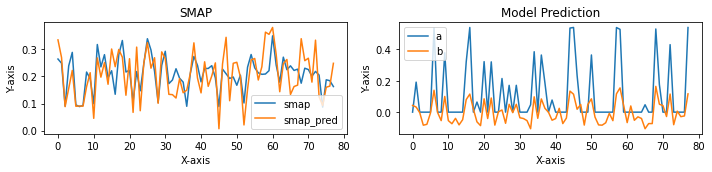

Epoch [113/5000] (LR: 6.25e-05):
Train loss: 0.1897 || Train physical loss: 0.0032 || Train similarity loss: 0.1865
Valid loss: 0.0039 || Valid physical loss: 0.0039 || Valid similarity loss: 0.0000


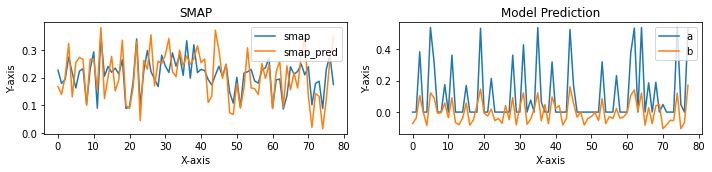

Epoch [114/5000] (LR: 6.25e-05):
Train loss: 0.1895 || Train physical loss: 0.0032 || Train similarity loss: 0.1862
Valid loss: 0.0041 || Valid physical loss: 0.0041 || Valid similarity loss: 0.0000


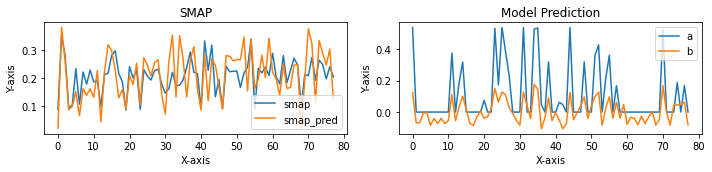

Epoch [115/5000] (LR: 6.25e-05):
Train loss: 0.1902 || Train physical loss: 0.0034 || Train similarity loss: 0.1868
Valid loss: 0.0043 || Valid physical loss: 0.0043 || Valid similarity loss: 0.0000


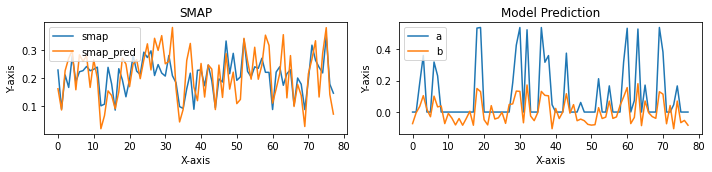

Epoch [116/5000] (LR: 6.25e-05):
Train loss: 0.0036 || Train physical loss: 0.0036 || Train similarity loss: 0.0000
Valid loss: 0.0045 || Valid physical loss: 0.0045 || Valid similarity loss: 0.0000


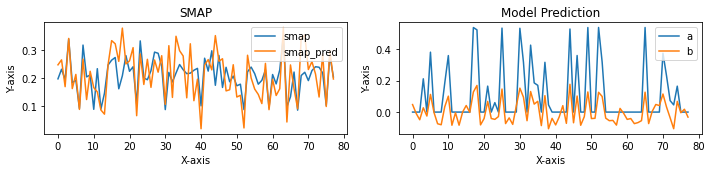

Epoch [117/5000] (LR: 6.25e-05):
Train loss: 0.0036 || Train physical loss: 0.0036 || Train similarity loss: 0.0000
Valid loss: 0.0044 || Valid physical loss: 0.0044 || Valid similarity loss: 0.0000


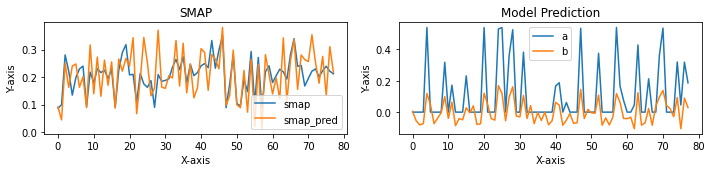

Epoch [118/5000] (LR: 6.25e-05):
Train loss: 0.0036 || Train physical loss: 0.0036 || Train similarity loss: 0.0000
Valid loss: 0.0041 || Valid physical loss: 0.0041 || Valid similarity loss: 0.0000


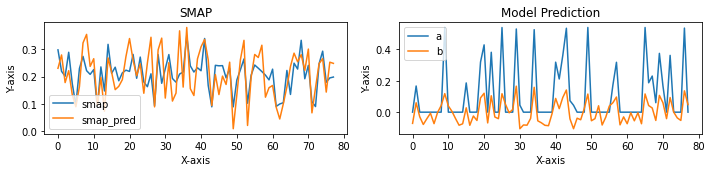

Epoch [119/5000] (LR: 6.25e-05):
Train loss: 0.1893 || Train physical loss: 0.0032 || Train similarity loss: 0.1861
Valid loss: 0.0040 || Valid physical loss: 0.0040 || Valid similarity loss: 0.0000


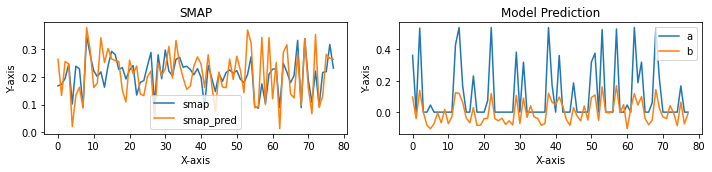

Epoch [120/5000] (LR: 3.125e-05):
Train loss: 0.1894 || Train physical loss: 0.0033 || Train similarity loss: 0.1861
Valid loss: 0.0041 || Valid physical loss: 0.0041 || Valid similarity loss: 0.0000


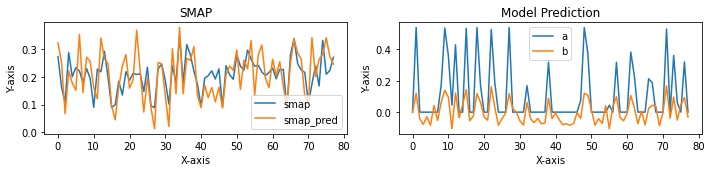

Epoch [121/5000] (LR: 3.125e-05):
Train loss: 0.0034 || Train physical loss: 0.0034 || Train similarity loss: 0.0000
Valid loss: 0.0041 || Valid physical loss: 0.0041 || Valid similarity loss: 0.0000


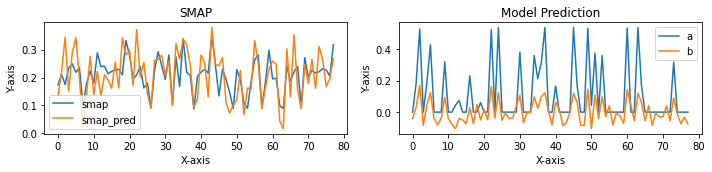

Epoch [122/5000] (LR: 3.125e-05):
Train loss: 0.1896 || Train physical loss: 0.0033 || Train similarity loss: 0.1862
Valid loss: 0.0042 || Valid physical loss: 0.0042 || Valid similarity loss: 0.0000


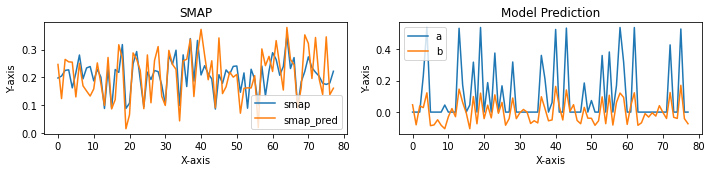

Epoch [123/5000] (LR: 3.125e-05):
Train loss: 0.0034 || Train physical loss: 0.0034 || Train similarity loss: 0.0000
Valid loss: 0.0042 || Valid physical loss: 0.0042 || Valid similarity loss: 0.0000


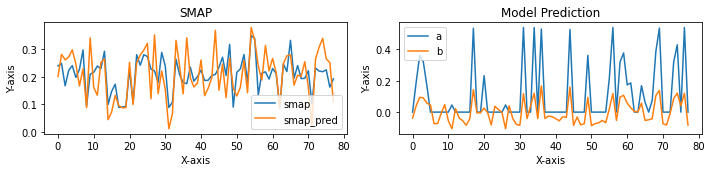

Epoch [124/5000] (LR: 3.125e-05):
Train loss: 0.0034 || Train physical loss: 0.0034 || Train similarity loss: 0.0000
Valid loss: 0.0040 || Valid physical loss: 0.0040 || Valid similarity loss: 0.0000


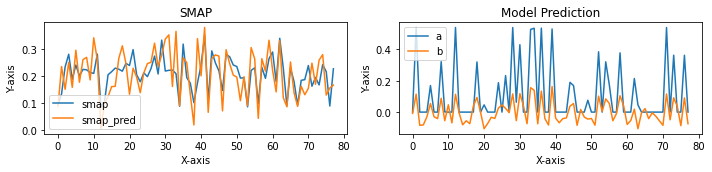

Epoch [125/5000] (LR: 3.125e-05):
Train loss: 0.0033 || Train physical loss: 0.0033 || Train similarity loss: 0.0000
Valid loss: 0.0040 || Valid physical loss: 0.0040 || Valid similarity loss: 0.0000


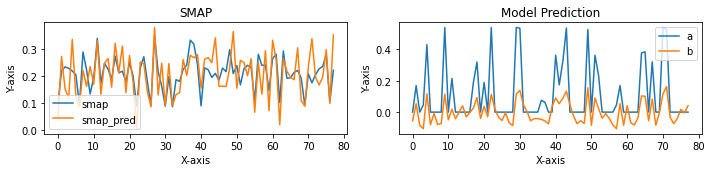

Epoch [126/5000] (LR: 3.125e-05):
Train loss: 0.1895 || Train physical loss: 0.0032 || Train similarity loss: 0.1862
Valid loss: 0.0039 || Valid physical loss: 0.0039 || Valid similarity loss: 0.0000


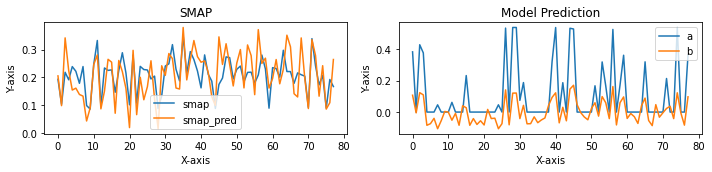

Epoch [127/5000] (LR: 3.125e-05):
Train loss: 0.3757 || Train physical loss: 0.0032 || Train similarity loss: 0.3725
Valid loss: 0.0041 || Valid physical loss: 0.0041 || Valid similarity loss: 0.0000


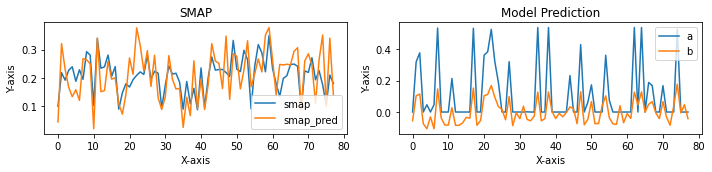

Epoch [128/5000] (LR: 3.125e-05):
Train loss: 0.1897 || Train physical loss: 0.0034 || Train similarity loss: 0.1863
Valid loss: 0.0044 || Valid physical loss: 0.0044 || Valid similarity loss: 0.0000


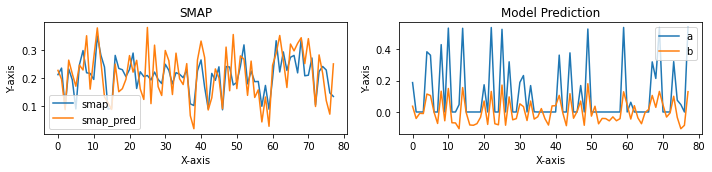

Epoch [129/5000] (LR: 3.125e-05):
Train loss: 0.0035 || Train physical loss: 0.0035 || Train similarity loss: 0.0000
Valid loss: 0.0045 || Valid physical loss: 0.0045 || Valid similarity loss: 0.0000


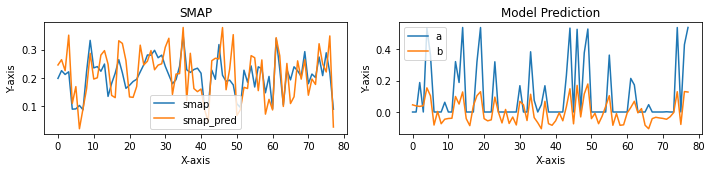

Epoch [130/5000] (LR: 3.125e-05):
Train loss: 0.0036 || Train physical loss: 0.0036 || Train similarity loss: 0.0000
Valid loss: 0.0044 || Valid physical loss: 0.0044 || Valid similarity loss: 0.0000


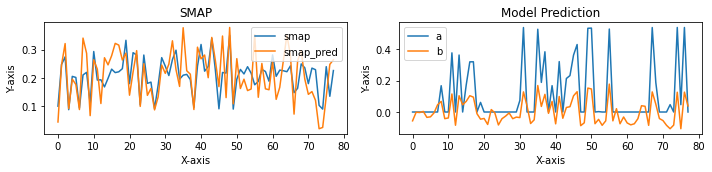

Epoch [131/5000] (LR: 1.5625e-05):
Train loss: 0.0036 || Train physical loss: 0.0036 || Train similarity loss: 0.0000
Valid loss: 0.0044 || Valid physical loss: 0.0044 || Valid similarity loss: 0.0000


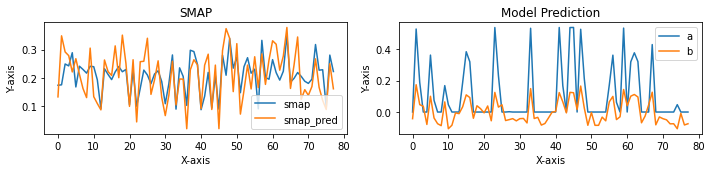

Epoch [132/5000] (LR: 1.5625e-05):
Train loss: 0.0035 || Train physical loss: 0.0035 || Train similarity loss: 0.0000
Valid loss: 0.0043 || Valid physical loss: 0.0043 || Valid similarity loss: 0.0000


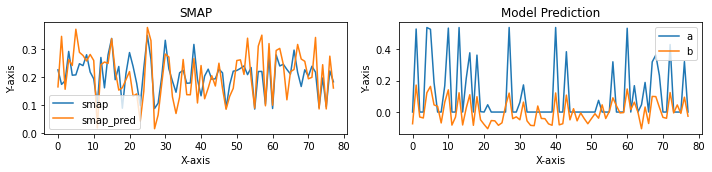

Epoch [133/5000] (LR: 1.5625e-05):
Train loss: 0.0034 || Train physical loss: 0.0034 || Train similarity loss: 0.0000
Valid loss: 0.0042 || Valid physical loss: 0.0042 || Valid similarity loss: 0.0000


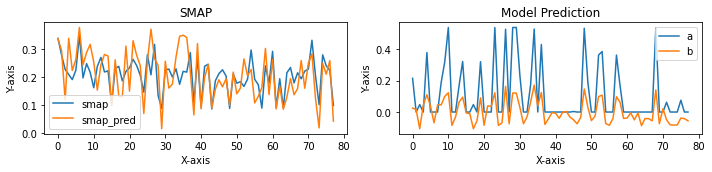

Epoch [134/5000] (LR: 1.5625e-05):
Train loss: 0.1896 || Train physical loss: 0.0035 || Train similarity loss: 0.1860
Valid loss: 0.0042 || Valid physical loss: 0.0042 || Valid similarity loss: 0.0000


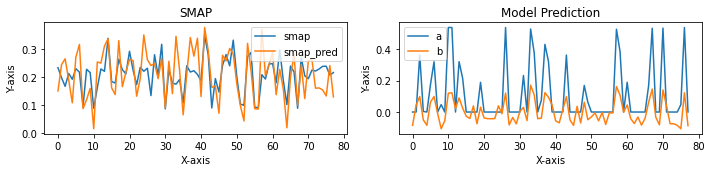

Epoch [135/5000] (LR: 1.5625e-05):
Train loss: 0.1894 || Train physical loss: 0.0033 || Train similarity loss: 0.1860
Valid loss: 0.0042 || Valid physical loss: 0.0042 || Valid similarity loss: 0.0000


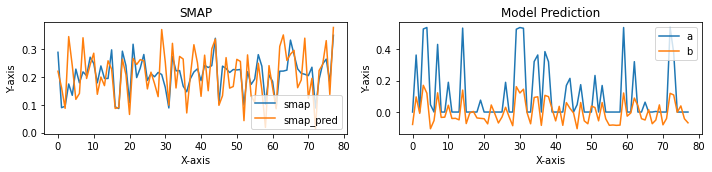

Epoch [136/5000] (LR: 1.5625e-05):
Train loss: 0.0034 || Train physical loss: 0.0034 || Train similarity loss: 0.0000
Valid loss: 0.0041 || Valid physical loss: 0.0041 || Valid similarity loss: 0.0000


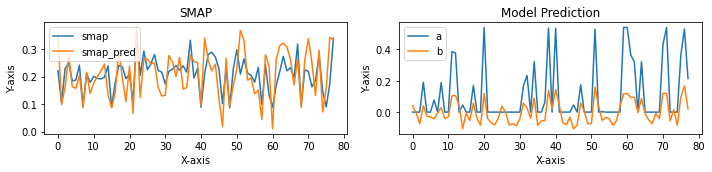

Epoch [137/5000] (LR: 1.5625e-05):
Train loss: 0.0034 || Train physical loss: 0.0034 || Train similarity loss: 0.0000
Valid loss: 0.0040 || Valid physical loss: 0.0040 || Valid similarity loss: 0.0000


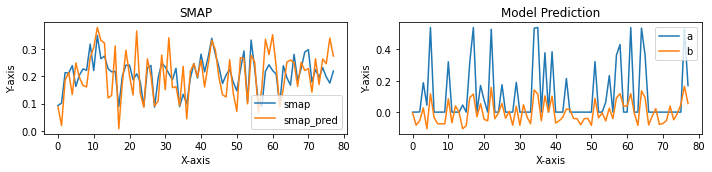

Epoch [138/5000] (LR: 1.5625e-05):
Train loss: 0.0033 || Train physical loss: 0.0033 || Train similarity loss: 0.0000
Valid loss: 0.0040 || Valid physical loss: 0.0040 || Valid similarity loss: 0.0000


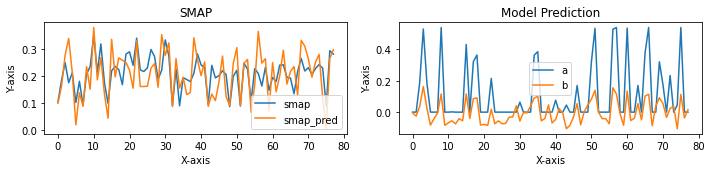

Epoch [139/5000] (LR: 1.5625e-05):
Train loss: 0.0034 || Train physical loss: 0.0034 || Train similarity loss: 0.0000
Valid loss: 0.0039 || Valid physical loss: 0.0039 || Valid similarity loss: 0.0000


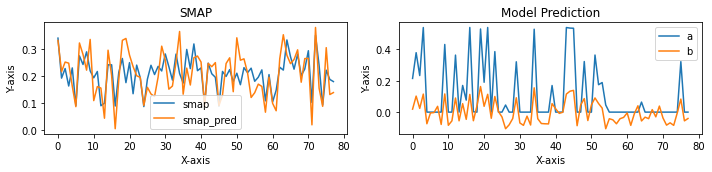

Epoch [140/5000] (LR: 1.5625e-05):
Train loss: 0.1894 || Train physical loss: 0.0032 || Train similarity loss: 0.1861
Valid loss: 0.0039 || Valid physical loss: 0.0039 || Valid similarity loss: 0.0000


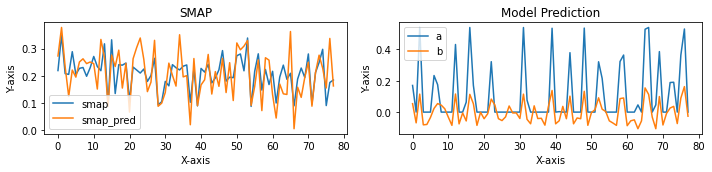

Epoch [141/5000] (LR: 1.5625e-05):
Train loss: 0.0033 || Train physical loss: 0.0033 || Train similarity loss: 0.0000
Valid loss: 0.0039 || Valid physical loss: 0.0039 || Valid similarity loss: 0.0000

Model is not improving, so we halt the training session.


In [8]:
# 创建模型保存目录
if os.path.exists(config['model_save_dir'])==False:
    os.makedirs(config['model_save_dir'], exist_ok=True)
    
if config['is_train']==True:
    print(dataset.get_input_shape(0))
    model = SMCNN(input_channel=dataset.get_input_shape(0)[2]).to(device) # put your model and data on the same computation device.
    print(model)
    trainer(train_loader, valid_loader, model, config, device)

## Testing

In [9]:
def tester(test_loader, model, config, device):
    relu = torch.nn.ReLU(inplace=True)
    criterion = self_defined_smap_loss
    model.eval() 
    loss_record = []
    physical_loss_record = []
    sim_loss_record = []
    for data_pkg in test_loader:
        x = data_pkg['processed_data']
        with torch.no_grad():
            pred = model(x)
            relu(pred[:, 0])
#             x, pred = x.to(device), pred.to(device)  
            physical_loss, sim_loss = criterion(pred, data_pkg['label_data'], 'Validing', config['sim_threshold'])
            loss = physical_loss + sim_loss

        physical_loss_record.append(physical_loss.item())
        sim_loss_record.append(sim_loss.item())
        loss_record.append(loss.item())

    mean_test_physical_loss = sum(physical_loss_record)/len(physical_loss_record)
    mean_test_sim_loss = sum(sim_loss_record)/len(sim_loss_record)
    mean_test_loss = sum(loss_record)/len(loss_record)

    print(f'Test loss: {mean_test_loss:.4f} || Valid physical loss: {mean_test_physical_loss:.4f} || Valid similarity loss: {mean_test_sim_loss:.4f}')
    return loss_record

## 用smap数据集检验预训练模型

(11, 11, 20)
SMCNN(
  (cnn): Sequential(
    (0): Conv2d(20, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(64, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
  )
  (fc): Sequential(
    (0): Linear(in_features=3872, out_features=4, bias=True)
    (1): ReLU()
    (2): Linear(in_features=4, out_features=2, bias=True)
  )
)


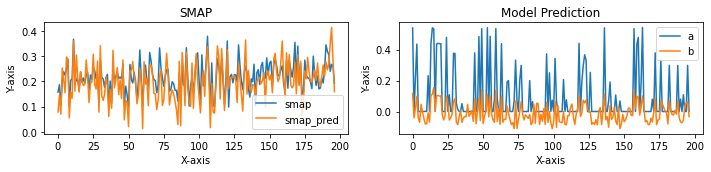

Test loss: 0.9356 || Valid physical loss: 0.0028 || Valid similarity loss: 0.9328


In [10]:
param_path = os.path.join(config['model_save_dir'],'first.ckpt' )
print(dataset.get_input_shape(0))
model = SMCNN(input_channel=dataset.get_input_shape(0)[2]).to(device)
print(model)
model.load_state_dict(torch.load(param_path))
loss_record = tester(test_loader, model, config, device) 

## 用SMAP数据集检验迁移模型

(11, 11, 20)
SMCNN(
  (cnn): Sequential(
    (0): Conv2d(20, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(64, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
  )
  (fc): Sequential(
    (0): Linear(in_features=3872, out_features=4, bias=True)
    (1): ReLU()
    (2): Linear(in_features=4, out_features=2, bias=True)
  )
)


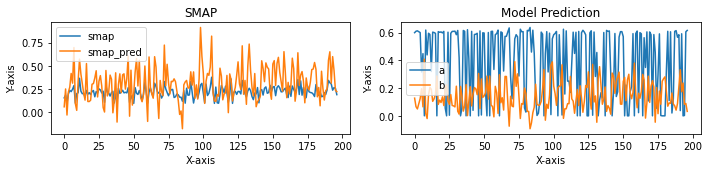

Test loss: 0.0340 || Valid physical loss: 0.0340 || Valid similarity loss: 0.0000


In [11]:
transf_model_root = 'D:\\1GRADUATED\\paper\\downscaling_data\\Soil_moisture_downscale_czt\\DATASET\\AB\\OUTPUT\\MODELS\\CNN_TRANSFER'
param_path = os.path.join(transf_model_root,'first.ckpt' )
print(dataset.get_input_shape(0))
model = SMCNN(input_channel=dataset.get_input_shape(0)[2]).to(device)
print(model)
model.load_state_dict(torch.load(param_path))
loss_record = tester(test_loader, model, config, device) 

## 用SMAP数据集检验站点数据单独训练的模型

(11, 11, 20)
SMCNN(
  (cnn): Sequential(
    (0): Conv2d(20, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(64, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
  )
  (fc): Sequential(
    (0): Linear(in_features=3872, out_features=4, bias=True)
    (1): ReLU()
    (2): Linear(in_features=4, out_features=2, bias=True)
  )
)


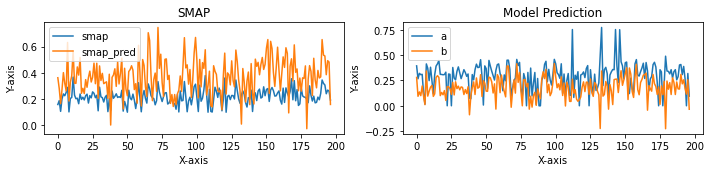

Test loss: 0.0358 || Valid physical loss: 0.0358 || Valid similarity loss: 0.0000


In [12]:
insitu_model_root = 'D:\\1GRADUATED\\paper\\downscaling_data\\Soil_moisture_downscale_czt\\DATASET\\AB\\OUTPUT\\MODELS\\CNN_FROM_INSITU'
param_path = os.path.join(insitu_model_root,'first.ckpt' )
print(dataset.get_input_shape(0))
model = SMCNN(input_channel=dataset.get_input_shape(0)[2]).to(device)
print(model)
model.load_state_dict(torch.load(param_path))
loss_record = tester(test_loader, model, config, device) 